In this example, we take the Sanfrancisco 311 Call center data for last 10 years and
use this to predict the Call volume for the next 3 months, and show the Root mean square error (RMSE), 
using different approaches, ie the traditional ARMA, and Deep Learning techniques like Sequence models with LSTM 

In [4]:
import pandas
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import math
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from pandas.plotting import scatter_matrix

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
from keras.models import Sequential
from keras.layers import Dense   
from keras import optimizers

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from pandas import DataFrame
from pandas import concat
from keras.models import load_model
from keras import optimizers
from matplotlib import pyplot
from math import sqrt
from keras import optimizers

numpy.random.seed(7)

# load the dataset
dataframe = pandas.read_csv('C:/users/hackuser1/Hackathon18/311_call_metrics.csv', header=0, engine='python', skipfooter=3)
dataframe['month'] = pd.to_datetime(dataframe.month)
dataframe=dataframe.sort_values(by='month',ascending=True)
dataframe.head()
regr_dataset = dataframe.copy()

In [209]:
corr_matrix = dataframe.corr()
corr_matrix["calls_answered"].sort_values(ascending=False)

calls_answered                   1.000000
svc_level_answered_w_i_60_sec    0.455217
avg_speed_answer_sec            -0.605058
transferred_calls               -0.850102
Name: calls_answered, dtype: float64

The correlation matrix shows high correlation between the calls_answered and transferred_calls. 
In order to minimize transferred calls, it is important to predict the call volume accurately.
We first consider the Calls_answered as TimeSeries data and predict the same for next 3 months.
We develop Regression relation between Calls_Answered and transferred_calls and use this model to predict 
transferred_calls for next 3 months. 

Next we sort the data based on the month and plot the data, to observe the trends. Since we are now going to 
predict the Call Volume of next 3 months based on historical data of Call Volume, we take the month and 
Call volume in our dataset

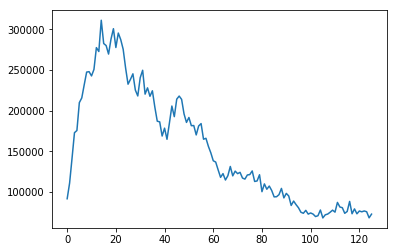

In [5]:
dataframe = dataframe.iloc[:,0:2]
dataset = dataframe.values[:,1:2]
dataset = dataset.astype('float32')

plt.plot(dataset)
plt.show()

Next we Scale the dataset using MinMaxScaler in a range of 0 to 1

In [3]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

We split the train and test data. We have 120 values, worth of 10 years of data, on a monthly basis. We take
20 values as test data, and remaining as train data. Since this is time series data, we take the first 106 values
as train data and next 20 values as test data

In [212]:
train_size = int(len(dataset)) - 20
test_size = 20
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

106 20


The next part is the most important step in creating the train data for a Supervised Learning problem.
We shift the data with a lookback of 10 time steps and use this data to predict the value of the Call volume 
at the next time step.

In [213]:
def createSupervisedTrainingSet(dataset,lookback):

    df = DataFrame()
    x = dataset
    
    len_series = x.shape[0]

    df['t'] = [x[i] for i in range(x.shape[0])]
    #create x values at time t
    x=df['t'].values
    
    cols=list()
    #create dataframe series for t+1,t+2,t+3, to be used as y values, during Supervised Learning
    #lookback = 10, means 10 values of TimeSeries (x) are used to predict the value at time t+1,t+2,t+3 (y)

    df['t+1'] = df['t'].shift(-lookback)
    cols.append(df['t+1'])
    df['t+2'] = df['t'].shift(-(lookback+1))
    cols.append(df['t+2'])
    df['t+3'] = df['t'].shift(-(lookback+2))
    cols.append(df['t+3'])
    agg = concat(cols,axis=1)
    y=agg.values

    x = x.reshape(x.shape[0],1)

    len_X = len_series-lookback-2
    X=np.zeros((len_X,lookback,1))
    Y=np.zeros((len_X,3))
 
    for i in range(len_X):
        X[i] = x[i:i+10]
        Y[i] = y[i]

    return X,Y
 

look_back = 10
trainX, trainY = createSupervisedTrainingSet(train, look_back)
testX,testY = createSupervisedTrainingSet(test, look_back)

In [16]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)
#Check the sample train X and train Y, as well as test X and test Y, and match with original time series data
print(np.around(scaler.inverse_transform(testX[7,:])))
print(np.around(scaler.inverse_transform(testY[7,:])))
print(np.around(scaler.inverse_transform(trainX[93,:,:])))
print(np.around(scaler.inverse_transform(trainY[93,:])))
print(np.around(scaler.inverse_transform(dataset[93:106])))        
#use a lookback value of 10, so the value at t is 10 steps behind the value at t+1
#As can be seen the 10 values of Time Series (Call Volume) from index 93 are being used as X to 
#predict the 3 values coming next (t+1,t+2,t+3)

(94, 10, 1)
(94, 3)
(8, 10, 1)
(8, 3)
[[ 80919.]
 [ 74029.]
 [ 76264.]
 [ 88607.]
 [ 73473.]
 [ 79410.]
 [ 73427.]
 [ 76847.]
 [ 75870.]
 [ 76892.]]
[ 75949.  68468.  72996.]
[[ 89074.]
 [ 84685.]
 [ 80836.]
 [ 75324.]
 [ 74064.]
 [ 77644.]
 [ 73027.]
 [ 74445.]
 [ 73047.]
 [ 70038.]]
[ 71042.  78059.  68355.]
[[ 89074.]
 [ 84685.]
 [ 80836.]
 [ 75324.]
 [ 74064.]
 [ 77644.]
 [ 73027.]
 [ 74445.]
 [ 73047.]
 [ 70038.]
 [ 71042.]
 [ 78059.]
 [ 68355.]]


/home/anirban/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/anirban/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Use a Deep Learning technique with one hidden layer of 20 LSTM cells, outputting into 3 values, ie the predictions
at time t+1,t+2,t+3. Input layer being 10 by 1 in size, for the 10 prior values of time series.

In [214]:
model = Sequential()
model.add(LSTM(20, input_shape=(look_back, 1)))
model.add(Dense(3))
myOptimizer = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=0.01, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=myOptimizer)
history = model.fit(trainX, trainY, epochs=200,  validation_data=(testX,testY), batch_size=5, verbose=2)

Train on 94 samples, validate on 8 samples
Epoch 1/200
 - 0s - loss: 0.1597 - val_loss: 0.0500
Epoch 2/200


C:\Anaconda\lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input38716") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))
C:\Anaconda\lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input39175") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


 - 0s - loss: 0.0602 - val_loss: 0.1085
Epoch 3/200
 - 0s - loss: 0.0457 - val_loss: 0.0597
Epoch 4/200
 - 0s - loss: 0.0334 - val_loss: 0.0346
Epoch 5/200
 - 0s - loss: 0.0220 - val_loss: 0.0190
Epoch 6/200
 - 0s - loss: 0.0134 - val_loss: 0.0022
Epoch 7/200
 - 0s - loss: 0.0088 - val_loss: 5.4796e-04
Epoch 8/200
 - 0s - loss: 0.0078 - val_loss: 5.7048e-04
Epoch 9/200
 - 0s - loss: 0.0075 - val_loss: 6.5423e-04
Epoch 10/200
 - 0s - loss: 0.0080 - val_loss: 4.9321e-04
Epoch 11/200
 - 0s - loss: 0.0073 - val_loss: 2.5375e-04
Epoch 12/200
 - 0s - loss: 0.0072 - val_loss: 8.1137e-04
Epoch 13/200
 - 0s - loss: 0.0073 - val_loss: 6.0985e-04
Epoch 14/200
 - 0s - loss: 0.0073 - val_loss: 4.4984e-04
Epoch 15/200
 - 0s - loss: 0.0069 - val_loss: 3.3067e-04
Epoch 16/200
 - 0s - loss: 0.0069 - val_loss: 2.8237e-04
Epoch 17/200
 - 0s - loss: 0.0068 - val_loss: 4.2035e-04
Epoch 18/200
 - 0s - loss: 0.0064 - val_loss: 0.0010
Epoch 19/200
 - 0s - loss: 0.0063 - val_loss: 0.0010
Epoch 20/200
 - 0s - l

Epoch 147/200
 - 0s - loss: 0.0042 - val_loss: 3.6685e-04
Epoch 148/200
 - 0s - loss: 0.0041 - val_loss: 3.0281e-04
Epoch 149/200
 - 0s - loss: 0.0040 - val_loss: 3.4973e-04
Epoch 150/200
 - 0s - loss: 0.0042 - val_loss: 3.5998e-04
Epoch 151/200
 - 0s - loss: 0.0042 - val_loss: 7.5974e-04
Epoch 152/200
 - 0s - loss: 0.0043 - val_loss: 4.7951e-04
Epoch 153/200
 - 0s - loss: 0.0040 - val_loss: 4.4373e-04
Epoch 154/200
 - 0s - loss: 0.0039 - val_loss: 5.2820e-04
Epoch 155/200
 - 0s - loss: 0.0042 - val_loss: 3.8693e-04
Epoch 156/200
 - 0s - loss: 0.0041 - val_loss: 5.2915e-04
Epoch 157/200
 - 0s - loss: 0.0040 - val_loss: 3.3282e-04
Epoch 158/200
 - 0s - loss: 0.0042 - val_loss: 5.9155e-04
Epoch 159/200
 - 0s - loss: 0.0040 - val_loss: 3.9107e-04
Epoch 160/200
 - 0s - loss: 0.0043 - val_loss: 6.7660e-04
Epoch 161/200
 - 0s - loss: 0.0042 - val_loss: 5.8663e-04
Epoch 162/200
 - 0s - loss: 0.0039 - val_loss: 3.5724e-04
Epoch 163/200
 - 0s - loss: 0.0042 - val_loss: 6.1838e-04
Epoch 164/200


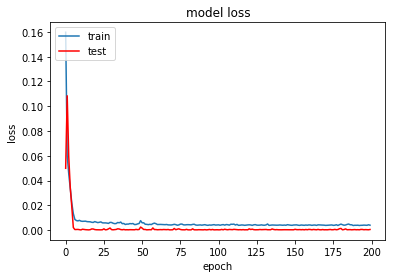

In [169]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], color=  'red')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Once the model is trained, use it to make a prediction on the test data

In [215]:
testPredict = model.predict(testX)
predictUnscaled = np.around(scaler.inverse_transform(testPredict))
testYUnscaled = np.around(scaler.inverse_transform(testY))
#print the actual and predicted values at t+3
print(testYUnscaled[:,2])
print(predictUnscaled[:,2])

[ 79410.  73427.  76847.  75870.  76892.  75949.  68468.  72996.]
[ 68651.  75061.  69936.  70445.  67384.  67674.  67516.  68051.]


C:\Anaconda\lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input38716") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


In [ ]:
Plot the predicted and actual values at time t+1,t+2,t+3

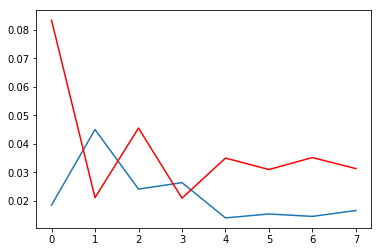

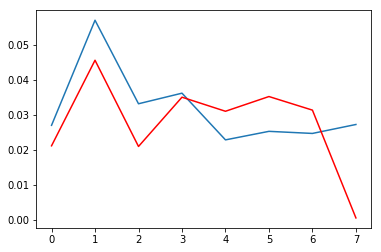

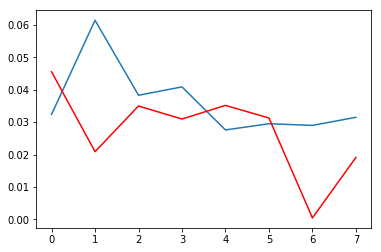

In [15]:
pyplot.plot(testPredict[:,0])
pyplot.plot(testY[:,0],color='red')
pyplot.show()

pyplot.plot(testPredict[:,1])
pyplot.plot(testY[:,1],color='red')
pyplot.show()

pyplot.plot(testPredict[:,2])
pyplot.plot(testY[:,2],color='red')
pyplot.show()

Evaluate the RMSE values at t+1,t+2,t+3 to compare with other approaches, and select the best approach

In [21]:
def evaluate_forecasts(actuals, forecasts, n_seq):
    	for i in range(n_seq):
            actual = actuals[:,i]
            predicted = forecasts[:,i]
            rmse = sqrt(mean_squared_error(actual, predicted))
            print('t+%d RMSE: %f' % ((i+1), rmse))
        
evaluate_forecasts(testYUnscaled, predictUnscaled,3)

t+1 RMSE: 5765.188028
t+2 RMSE: 3753.886469
t+3 RMSE: 4398.008527


It can be clearly seen, the RMSE values are much better than traditional ARMA models, and hence Deep Learning 
is useful in this scenario to predict the Call Volume at time t+1,t+2 and t+3

We try to improve the DeepLearning approach further by using Grid Search of Neural Network parameters
using sklearn wrapper for Keras, KerasRegressor, and GridSearchCV.
First, we tune best batch size and number of epochs

In [6]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
# Function to create model, required for KerasRegressor
def create_model():
    model = Sequential()
    model.add(LSTM(20, input_shape=(look_back, 1)))
    model.add(Dense(3))
    myOptimizer = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=0.01, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer=myOptimizer,metrics=['mse'])
    return model


In [7]:
# create model
model = KerasRegressor(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [5,10,20]
epochs = [50, 100 , 200]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(trainX, trainY)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.005838 using {'batch_size': 5, 'epochs': 200}


We find batch size : 5 and epochs : 200 gives best results
Next, we tune the parameters of the optimization algorithm

In [7]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
def create_model(learn_rate=0.01, beta1=0.9, beta2=0.999):
    model = Sequential()
    model.add(LSTM(20, input_shape=(look_back, 1)))
    model.add(Dense(3))
    myOptimizer = optimizers.Adam(lr=learn_rate, beta_1=beta1, beta_2=beta2, epsilon=0.01, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer=myOptimizer,metrics=['mse'])
    return model
# create model
model = KerasRegressor(build_fn=create_model, epochs=200, batch_size=5, verbose=2)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1]
beta1 = [0.85, 0.9, 0.95]
beta2 = [0.990,0.995,0.999]
param_grid = dict(learn_rate=learn_rate, beta1=beta1, beta2=beta2)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(trainX, trainY)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Epoch 1/200
Epoch 1/200
Epoch 1/200
Epoch 1/200
 - 1s - loss: 0.0952 - mean_squared_error: 0.0952
 - 1s - loss: 0.3126 - mean_squared_error: 0.3126
Epoch 2/200
Epoch 2/200
 - 1s - loss: 0.0552 - mean_squared_error: 0.0552
Epoch 2/200
 - 1s - loss: 0.3843 - mean_squared_error: 0.3843
Epoch 2/200
 - 0s - loss: 0.2585 - mean_squared_error: 0.2585
Epoch 3/200
 - 0s - loss: 0.0750 - mean_squared_error: 0.0750
 - 0s - loss: 0.0255 - mean_squared_error: 0.0255
Epoch 3/200
 - 0s - loss: 0.3100 - mean_squared_error: 0.3100
Epoch 3/200
Epoch 3/200
 - 0s - loss: 0.2426 - mean_squared_error: 0.2426
 - 0s - loss: 0.2108 - mean_squared_error: 0.2108
Epoch 4/200
Epoch 4/200
 - 0s - loss: 0.0590 - mean_squared_error: 0.0590
 - 0s - loss: 0.0209 - mean_squared_error: 0.0209
Epoch 4/200
Epoch 4/200
 - 0s - loss: 0.1701 - mean_squared_error: 0.1701
Epoch 5/200
 - 0s - loss: 0.0467 - mean_squared_error: 0.0467
Epoch 5/200
 - 0s - loss: 0.0170 - mean_squared_error: 0.0170
Epoch 5/200
 - 0s - loss: 0.1851 -

Epoch 35/200
 - 0s - loss: 0.0182 - mean_squared_error: 0.0182
Epoch 34/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 33/200
 - 0s - loss: 0.0104 - mean_squared_error: 0.0104
Epoch 35/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 34/200
 - 0s - loss: 0.0106 - mean_squared_error: 0.0106
 - 0s - loss: 0.0175 - mean_squared_error: 0.0175
Epoch 35/200
Epoch 36/200
 - 0s - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 36/200
 - 0s - loss: 0.0171 - mean_squared_error: 0.0171
Epoch 36/200
 - 0s - loss: 0.0102 - mean_squared_error: 0.0102
Epoch 37/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
 - 0s - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 37/200
Epoch 35/200
 - 0s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 36/200
 - 0s - loss: 0.0165 - mean_squared_error: 0.0165
Epoch 37/200
 - 0s - loss: 0.0070 - mean_squared_error: 0.0070
 - 0s - loss: 0.0102 - mean_squared_error: 0.0102
Epoch 38/200
Epoch 38/200
 - 0s - loss: 0.0163 - mean_squared_error:

 - 0s - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 67/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 66/200
 - 0s - loss: 0.0093 - mean_squared_error: 0.0093
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 68/200
Epoch 67/200
 - 0s - loss: 0.0114 - mean_squared_error: 0.0114
Epoch 68/200
 - 0s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 67/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
 - 0s - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 68/200
Epoch 69/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 68/200
 - 0s - loss: 0.0112 - mean_squared_error: 0.0112
Epoch 69/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 69/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 69/200
 - 0s - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 70/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 70/200
 - 0s - loss: 0.0114 - mean_squared_error: 0.0114
Epoch 70/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch

Epoch 99/200
 - 0s - loss: 0.0099 - mean_squared_error: 0.0099
Epoch 100/200
 - 0s - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 102/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 97/200
 - 0s - loss: 0.0032 - mean_squared_error: 0.0032
 - 0s - loss: 0.0100 - mean_squared_error: 0.0100
Epoch 101/200
Epoch 100/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 98/200
 - 0s - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 103/200
 - 0s - loss: 0.0099 - mean_squared_error: 0.0099
Epoch 102/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 101/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 99/200
 - 0s - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 104/200
 - 0s - loss: 0.0099 - mean_squared_error: 0.0099
Epoch 103/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 102/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 100/200
 - 0s - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 105/200
 - 0s - loss: 0.0026 - mean_sq

Epoch 133/200
Epoch 129/200
 - 0s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 129/200
 - 0s - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 135/200
 - 0s - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 134/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 130/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 130/200
 - 0s - loss: 0.0089 - mean_squared_error: 0.0089
 - 0s - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 136/200
Epoch 135/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 131/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 131/200
 - 0s - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 137/200
 - 0s - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 136/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 132/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 132/200
 - 0s - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 138/200
 - 0s - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 137/200
 - 0s - loss

Epoch 166/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 160/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
 - 0s - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 162/200
 - 0s - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 167/200
Epoch 167/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 161/200
 - 0s - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 168/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 163/200
 - 0s - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 168/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 162/200
 - 0s - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 169/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 164/200
 - 0s - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 169/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 163/200
 - 0s - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 170/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 165/200
 - 0s - loss: 0.0025 - mea

 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 193/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 194/200
 - 0s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 198/200
 - 0s - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 199/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 195/200
Epoch 194/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 199/200
 - 0s - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 200/200
 - 0s - loss: 0.0076 - mean_squared_error: 0.0076
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 200/200
Epoch 196/200
 - 0s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 195/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 197/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 196/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 198/200
 - 0

Epoch 28/200
 - 0s - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 30/200
 - 0s - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 24/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 29/200
 - 0s - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 32/200
 - 0s - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 25/200
 - 0s - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 31/200
 - 0s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 30/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
 - 0s - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 33/200
Epoch 26/200
 - 0s - loss: 0.0087 - mean_squared_error: 0.0087
 - 0s - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 32/200
Epoch 31/200
 - 0s - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 34/200
 - 0s - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 33/200
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 32/200
 - 0s - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 27/200
 - 0s - loss: 0.0053 - mean_squared_error:

 - 0s - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 63/200
 - 0s - loss: 0.0065 - mean_squared_error: 0.0065
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 62/200
Epoch 62/200
 - 0s - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 64/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 58/200
 - 0s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 63/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 63/200
 - 0s - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 59/200
 - 0s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 65/200
 - 0s - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 64/200
 - 0s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 64/200
 - 0s - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 66/200
 - 0s - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 60/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 65/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 65/200
 - 0s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch

Epoch 95/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 96/200
 - 0s - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 90/200
 - 0s - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 94/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 97/200
 - 0s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 96/200
 - 0s - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 91/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 95/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 98/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 92/200
 - 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 97/200
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 96/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 99/200
 - 0s - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 93/200
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 97/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 100/200
 - 0s - loss: 0.0037 - mean_squared_error

Epoch 126/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
 - 0s - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 123/200
Epoch 129/200
 - 0s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 126/200
 - 0s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 124/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 127/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 130/200
 - 0s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 127/200
 - 0s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 125/200
 - 0s - loss: 0.0065 - mean_squared_error: 0.0065
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 131/200
Epoch 128/200
 - 0s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 128/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 126/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 132/200
 - 0s - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 129/200
 - 0s - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 127/200
 - 0s - loss: 0.0043 - mea

 - 0s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 159/200
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 158/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 161/200
 - 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 155/200
 - 0s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 160/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 159/200
 - 0s - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 162/200
 - 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 156/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 160/200
 - 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 161/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 163/200
 - 0s - loss: 0.0032 - mean_squared_error: 0.0032
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 161/200
Epoch 157/200
 - 0s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 162/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 164/200
 - 0s - loss: 0.0032 - mean_squared_erro

Epoch 191/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 193/200
 - 0s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 187/200
 - 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 190/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
 - 0s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 194/200
Epoch 192/200
 - 0s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 191/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 188/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 195/200
 - 0s - loss: 0.0055 - mean_squared_error: 0.0055
 - 0s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 189/200
Epoch 193/200
 - 0s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 192/200
 - 0s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 196/200
 - 0s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 190/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 197/200
 - 0s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 193/200
 - 0s - loss: 0.0057 - mea

Epoch 21/200
 - 0s - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 25/200
 - 0s - loss: 0.0148 - mean_squared_error: 0.0148
Epoch 22/200
 - 0s - loss: 0.0178 - mean_squared_error: 0.0178
Epoch 23/200
 - 0s - loss: 0.0234 - mean_squared_error: 0.0234
Epoch 22/200
 - 0s - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 26/200
 - 0s - loss: 0.0139 - mean_squared_error: 0.0139
Epoch 23/200
 - 0s - loss: 0.0164 - mean_squared_error: 0.0164
Epoch 24/200
 - 0s - loss: 0.0230 - mean_squared_error: 0.0230
Epoch 23/200
 - 0s - loss: 0.0109 - mean_squared_error: 0.0109
Epoch 27/200
 - 0s - loss: 0.0133 - mean_squared_error: 0.0133
Epoch 24/200
 - 0s - loss: 0.0152 - mean_squared_error: 0.0152
Epoch 25/200
 - 0s - loss: 0.0225 - mean_squared_error: 0.0225
Epoch 24/200
 - 0s - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 28/200
 - 0s - loss: 0.0144 - mean_squared_error: 0.0144
Epoch 26/200
 - 0s - loss: 0.0127 - mean_squared_error: 0.0127
Epoch 25/200
 - 0s - loss: 0.0221 - mean_squared_error:

 - 0s - loss: 0.0126 - mean_squared_error: 0.0126
 - 0s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 55/200
Epoch 53/200
 - 0s - loss: 0.0107 - mean_squared_error: 0.0107
Epoch 56/200
 - 0s - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 58/200
 - 0s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 54/200
 - 0s - loss: 0.0125 - mean_squared_error: 0.0125
Epoch 56/200
 - 0s - loss: 0.0104 - mean_squared_error: 0.0104
Epoch 57/200
 - 0s - loss: 0.0080 - mean_squared_error: 0.0080
 - 0s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 55/200
Epoch 59/200
 - 0s - loss: 0.0124 - mean_squared_error: 0.0124
Epoch 57/200
 - 0s - loss: 0.0104 - mean_squared_error: 0.0104
Epoch 58/200
 - 0s - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 60/200
 - 0s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 56/200
 - 0s - loss: 0.0105 - mean_squared_error: 0.0105
Epoch 59/200
 - 0s - loss: 0.0124 - mean_squared_error: 0.0124
Epoch 58/200
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch

Epoch 89/200
 - 0s - loss: 0.0105 - mean_squared_error: 0.0105
Epoch 90/200
 - 0s - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 89/200
 - 0s - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 90/200
 - 0s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 84/200
 - 0s - loss: 0.0087 - mean_squared_error: 0.0087
Epoch 91/200
 - 0s - loss: 0.0104 - mean_squared_error: 0.0104
 - 0s - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 90/200
Epoch 91/200
 - 0s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 85/200
 - 0s - loss: 0.0104 - mean_squared_error: 0.0104
Epoch 92/200
 - 0s - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 92/200
 - 0s - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 91/200
 - 0s - loss: 0.0104 - mean_squared_error: 0.0104
 - 0s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 93/200
Epoch 86/200
 - 0s - loss: 0.0088 - mean_squared_error: 0.0088
 - 0s - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 92/200
Epoch 93/200
 - 0s - loss: 0.0032 - mean_squared_error:

Epoch 116/200
 - 0s - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 120/200
 - 0s - loss: 0.0095 - mean_squared_error: 0.0095
 - 0s - loss: 0.0065 - mean_squared_error: 0.0065
 - 0s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 121/200
Epoch 124/200
Epoch 117/200
 - 0s - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 121/200
 - 0s - loss: 0.0032 - mean_squared_error: 0.0032
 - 0s - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 118/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 125/200
Epoch 122/200
 - 0s - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 122/200
 - 0s - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 126/200
 - 0s - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 123/200
 - 0s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 119/200
 - 0s - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 123/200
 - 0s - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 127/200
 - 0s - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 124/200
 - 0s - loss: 0.0032 - mea

Epoch 151/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 155/200
Epoch 149/200
 - 0s - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 154/200
 - 0s - loss: 0.0089 - mean_squared_error: 0.0089
 - 0s - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 156/200
Epoch 152/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 150/200
 - 0s - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 155/200
 - 0s - loss: 0.0086 - mean_squared_error: 0.0086
 - 0s - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 157/200
Epoch 153/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 151/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 156/200
 - 0s - loss: 0.0068 - mean_squared_error: 0.0068
 - 0s - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 154/200
Epoch 158/200
 - 0s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 152/200
 - 0s - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 157/200
 - 0s - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 159/200
 - 0s - loss

Epoch 187/200
 - 0s - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 184/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 183/200
 - 0s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 184/200
 - 0s - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 188/200
 - 0s - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 185/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 184/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 185/200
 - 0s - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 189/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 185/200
 - 0s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 186/200
 - 0s - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 186/200
 - 0s - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 190/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 186/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 187/200
 - 0s - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 187/200
 - 0s - loss: 0.0078 - mea

Epoch 16/200
 - 0s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 16/200
 - 0s - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 16/200
 - 0s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 20/200
 - 0s - loss: 0.0086 - mean_squared_error: 0.0086
Epoch 17/200
 - 0s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 17/200
 - 0s - loss: 0.0104 - mean_squared_error: 0.0104
Epoch 17/200
 - 0s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 21/200
 - 0s - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 18/200
 - 0s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 18/200
 - 0s - loss: 0.0096 - mean_squared_error: 0.0096
Epoch 18/200
 - 0s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 22/200
 - 0s - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 19/200
 - 0s - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 19/200
 - 0s - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 19/200
 - 0s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 23/200
 - 0s - loss: 0.0102 - mean_squared_error:

 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 51/200
 - 0s - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 50/200
 - 0s - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 48/200
 - 0s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 50/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 52/200
 - 0s - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 51/200
 - 0s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 49/200
 - 0s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 51/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 53/200
 - 0s - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 52/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 52/200
 - 0s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 50/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 54/200
 - 0s - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 53/200
 - 0s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 53/200
 - 0s - loss: 0.0040 - mean_squared_error: 0.0040
 - 0s

 - 0s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 81/200
Epoch 80/200
Epoch 83/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 84/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 84/200
 - 0s - loss: 0.0043 - mean_squared_error: 0.0043
 - 0s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 81/200
Epoch 82/200
 - 0s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 85/200
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 85/200
 - 0s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 82/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 83/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 86/200
 - 0s - loss: 0.0038 - mean_squared_error: 0.0038
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 86/200
Epoch 83/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 84/200
 - 0s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 87/200
 - 0s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 84/200
 - 0s - loss: 0.0030 - mean_s

Epoch 113/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 115/200
 - 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 113/200
 - 0s - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 117/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 114/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 116/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 118/200
 - 0s - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 114/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 115/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 117/200
 - 0s - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 119/200
 - 0s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 115/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 116/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 118/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 120/200
 - 0s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 116/200
 - 0s - loss: 0.0026 - mea

 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 147/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 147/200
 - 0s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 142/200
 - 0s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 151/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
 - 0s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 148/200
Epoch 148/200
 - 0s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 143/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 149/200
 - 0s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 152/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 149/200
 - 0s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 144/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 150/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 153/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 150/200
 - 0s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 145/200
 - 0s - loss: 0.0059 - mean_squared_erro

Epoch 173/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 181/200
 - 0s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 178/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 183/200
 - 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 174/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 182/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 179/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
 - 0s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 184/200
Epoch 175/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 180/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 183/200
 - 0s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 176/200
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 185/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 181/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 184/200
 - 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 177/200
 - 0s - loss: 0.0055 - mea

 - 0s - loss: 0.3068 - mean_squared_error: 0.3068
Epoch 3/200
 - 0s - loss: 0.0120 - mean_squared_error: 0.0120
 - 0s - loss: 0.0205 - mean_squared_error: 0.0205
Epoch 13/200
Epoch 13/200
 - 0s - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 16/200
 - 0s - loss: 0.2667 - mean_squared_error: 0.2667
Epoch 4/200
 - 0s - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 14/200
 - 0s - loss: 0.0199 - mean_squared_error: 0.0199
Epoch 14/200
 - 0s - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 17/200
 - 0s - loss: 0.2283 - mean_squared_error: 0.2283
Epoch 5/200
 - 0s - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 15/200
 - 0s - loss: 0.0193 - mean_squared_error: 0.0193
 - 0s - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 15/200
Epoch 18/200
 - 0s - loss: 0.1937 - mean_squared_error: 0.1937
Epoch 6/200
 - 0s - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 16/200
 - 0s - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 19/200
 - 0s - loss: 0.0189 - mean_squared_error: 0.0189
Epoch 16/

Epoch 45/200
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 47/200
 - 0s - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 46/200
 - 0s - loss: 0.0133 - mean_squared_error: 0.0133
Epoch 37/200
 - 0s - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 46/200
 - 0s - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 48/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 47/200
 - 0s - loss: 0.0127 - mean_squared_error: 0.0127
Epoch 38/200
 - 0s - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 47/200
 - 0s - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 48/200
 - 0s - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 49/200
 - 0s - loss: 0.0124 - mean_squared_error: 0.0124
Epoch 39/200
 - 0s - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 48/200
 - 0s - loss: 0.0120 - mean_squared_error: 0.0120
Epoch 40/200
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 49/200
 - 0s - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 50/200
 - 0s - loss: 0.0064 - mean_squared_error:

 - 0s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 78/200
 - 0s - loss: 0.0103 - mean_squared_error: 0.0103
Epoch 69/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
 - 0s - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 79/200
Epoch 80/200
 - 0s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 79/200
 - 0s - loss: 0.0104 - mean_squared_error: 0.0104
Epoch 70/200
 - 0s - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 81/200
 - 0s - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 80/200
 - 0s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 80/200
 - 0s - loss: 0.0104 - mean_squared_error: 0.0104
Epoch 71/200
 - 0s - loss: 0.0067 - mean_squared_error: 0.0067
 - 0s - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 82/200
Epoch 81/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
 - 0s - loss: 0.0102 - mean_squared_error: 0.0102
Epoch 72/200
Epoch 81/200
 - 0s - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 83/200
 - 0s - loss: 0.0068 - mean_squared_error: 0.0068
Epoch

Epoch 103/200
 - 0s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 112/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 109/200
Epoch 111/200
 - 0s - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 104/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 113/200
 - 0s - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 112/200
 - 0s - loss: 0.0096 - mean_squared_error: 0.0096
Epoch 105/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 110/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 114/200
 - 0s - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 113/200
 - 0s - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 106/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 111/200
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 114/200
 - 0s - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 115/200
 - 0s - loss: 0.0093 - mean_squared_error: 0.0093
 - 0s - loss: 0.0030 - mean_squared_erro

Epoch 144/200
Epoch 141/200
 - 0s - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 136/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 142/200
 - 0s - loss: 0.0033 - mean_squared_error: 0.0033
 - 0s - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 142/200
Epoch 145/200
 - 0s - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 137/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 143/200
 - 0s - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 138/200
 - 0s - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 143/200
 - 0s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 146/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 144/200
 - 0s - loss: 0.0085 - mean_squared_error: 0.0085
 - 0s - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 139/200
Epoch 144/200
 - 0s - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 147/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
 - 0s - loss: 0.0087 - mean_squared_error: 0.0087
Epoch 140/200
Epoch 145/200
 - 0s - loss

Epoch 173/200
Epoch 174/200
Epoch 175/200
 - 0s - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 169/200
 - 0s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 176/200
 - 0s - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 175/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 174/200
 - 0s - loss: 0.0080 - mean_squared_error: 0.0080
 - 0s - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 170/200
Epoch 177/200
 - 0s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 176/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 175/200
 - 0s - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 171/200
 - 0s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 178/200
 - 0s - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 177/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 176/200
 - 0s - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 172/200
 - 0s - loss: 0.0069 - mean_squared_error: 0.0069
 - 0s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 178/200
Epoch 179/20

 - 0s - loss: 0.0375 - mean_squared_error: 0.0375
Epoch 4/200
 - 0s - loss: 0.0821 - mean_squared_error: 0.0821
 - 0s - loss: 0.0086 - mean_squared_error: 0.0086
Epoch 8/200
Epoch 8/200
 - 0s - loss: 0.0259 - mean_squared_error: 0.0259
Epoch 5/200
 - 0s - loss: 0.0629 - mean_squared_error: 0.0629
Epoch 9/200
 - 0s - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 9/200
 - 0s - loss: 0.0150 - mean_squared_error: 0.0150
Epoch 6/200
 - 0s - loss: 0.0496 - mean_squared_error: 0.0496
Epoch 10/200
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 10/200
 - 0s - loss: 0.0121 - mean_squared_error: 0.0121
Epoch 7/200
 - 0s - loss: 0.0422 - mean_squared_error: 0.0422
Epoch 11/200
 - 2s - loss: 0.2094 - mean_squared_error: 0.2094
Epoch 2/200
 - 0s - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 11/200
 - 0s - loss: 0.0383 - mean_squared_error: 0.0383
Epoch 12/200
 - 0s - loss: 0.0113 - mean_squared_error: 0.0113
Epoch 8/200
 - 0s - loss: 0.0448 - mean_squared_error: 0.0448
Epoch 3/200
 - 

 - 0s - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 41/200
Epoch 39/200
 - 0s - loss: 0.0086 - mean_squared_error: 0.0086
Epoch 31/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 41/200
 - 0s - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 32/200
 - 0s - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 40/200
 - 0s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 42/200
 - 0s - loss: 0.0199 - mean_squared_error: 0.0199
Epoch 42/200
 - 0s - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 33/200
 - 0s - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 43/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 41/200
 - 0s - loss: 0.0194 - mean_squared_error: 0.0194
Epoch 43/200
 - 0s - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 34/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 44/200
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 42/200
 - 0s - loss: 0.0189 - mean_squared_error: 0.0189
Epoch 44/200
 - 0s - loss: 0.0082 - mean_squared_error:

Epoch 74/200
Epoch 72/200
 - 0s - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 64/200
 - 0s - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 72/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
 - 0s - loss: 0.0126 - mean_squared_error: 0.0126
Epoch 73/200
Epoch 75/200
 - 0s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 73/200
 - 0s - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 65/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
 - 0s - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 66/200
Epoch 76/200
 - 0s - loss: 0.0126 - mean_squared_error: 0.0126
Epoch 74/200
 - 0s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 74/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 77/200
 - 0s - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 67/200
 - 0s - loss: 0.0124 - mean_squared_error: 0.0124
Epoch 75/200
 - 0s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 75/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 78/200
 - 0s - loss: 0.0125 - mean_s

Epoch 96/200
 - 0s - loss: 0.0112 - mean_squared_error: 0.0112
Epoch 105/200
 - 0s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 105/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 107/200
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 97/200
 - 0s - loss: 0.0108 - mean_squared_error: 0.0108
Epoch 106/200
 - 0s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 106/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 108/200
 - 0s - loss: 0.0110 - mean_squared_error: 0.0110
Epoch 107/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 98/200
 - 0s - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 107/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 109/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 99/200
 - 0s - loss: 0.0108 - mean_squared_error: 0.0108
Epoch 108/200
 - 0s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 108/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 110/200
 - 0s - loss: 0.0057 - mean_sq

 - 0s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 129/200
 - 0s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 136/200
 - 0s - loss: 0.0099 - mean_squared_error: 0.0099
Epoch 137/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 130/200
Epoch 140/200
 - 0s - loss: 0.0098 - mean_squared_error: 0.0098
 - 0s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 137/200
Epoch 138/200
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 131/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 141/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 132/200
 - 0s - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 138/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 142/200
 - 0s - loss: 0.0098 - mean_squared_error: 0.0098
Epoch 139/200
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 133/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 143/200
 - 0s - loss: 0.0042 - mean_squared_erro

 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 171/200
Epoch 163/200
 - 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 167/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 172/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 164/200
 - 0s - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 169/200
 - 0s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 168/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 173/200
 - 0s - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 165/200
 - 0s - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 170/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 174/200
 - 0s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 169/200
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 166/200
 - 0s - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 171/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
 - 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 175/200
Epoch 170/200
 - 0s - loss: 0.0057 - mea

Epoch 195/200
 - 0s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 200/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
 - 0s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 196/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 197/200
 - 0s - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 198/200
 - 0s - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 199/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 200/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 1/200
Epoch 1/200
Epoch 1/200
 - 1s - loss: 0.0344 - mean_squared_error: 0.0344
Epoch 2/200
Epoch 1/200
 - 0s - loss: 0.0175 - mean_squared_error: 0.0175
Epoch 3/200
 - 1s - loss: 0.0946 - mean_squared_error: 0.0946
Epoch 2/200
 - 0s - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 4/200
 - 1s - loss: 0.0677 - mean_squared_error: 0.0677
Epoch 2/200
 - 0s - loss: 0.0282 - mean_squared_error: 0.0282
Epoch 3/200
 - 0s - loss: 0.0179 - mean_squared_error: 0.0179
Epoch 3/200
 - 0s - loss: 0.0047

 - 0s - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 33/200
 - 0s - loss: 0.0163 - mean_squared_error: 0.0163
Epoch 27/200
 - 0s - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 34/200
 - 0s - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 36/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
 - 0s - loss: 0.0070 - mean_squared_error: 0.0070
 - 0s - loss: 0.0157 - mean_squared_error: 0.0157
Epoch 35/200
Epoch 34/200
Epoch 28/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 35/200
 - 0s - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 36/200
 - 0s - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 37/200
 - 0s - loss: 0.0151 - mean_squared_error: 0.0151
Epoch 29/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 36/200
 - 0s - loss: 0.0146 - mean_squared_error: 0.0146
Epoch 30/200
 - 0s - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 37/200
 - 0s - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 38/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch

Epoch 67/200
 - 0s - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 66/200
 - 0s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 60/200
 - 0s - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 67/200
 - 0s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 68/200
 - 0s - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 67/200
 - 0s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 61/200
 - 0s - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 68/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 69/200
 - 0s - loss: 0.0033 - mean_squared_error: 0.0033
 - 0s - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 68/200
Epoch 62/200
 - 0s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 70/200
 - 0s - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 69/200
 - 0s - loss: 0.0033 - mean_squared_error: 0.0033
 - 0s - loss: 0.0097 - mean_squared_error: 0.0097
Epoch 63/200
Epoch 69/200
 - 0s - loss: 0.0084 - mean_squared_error: 0.0084
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch

 - 0s - loss: 0.0069 - mean_squared_error: 0.0069
 - 0s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 99/200
Epoch 102/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 91/200
 - 0s - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 100/200
 - 0s - loss: 0.0053 - mean_squared_error: 0.0053
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 99/200
Epoch 103/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 92/200
 - 0s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 101/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 93/200
 - 0s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 100/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 104/200
 - 0s - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 102/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 94/200
 - 0s - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 101/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 105/200
 - 0s - loss: 0.0093 - mean_squared_error: 0.0

Epoch 131/200
 - 0s - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 130/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 135/200
 - 0s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 132/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 123/200
 - 0s - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 131/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 136/200
 - 0s - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 133/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 132/200
Epoch 124/200
 - 0s - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 137/200
 - 0s - loss: 0.0044 - mean_squared_error: 0.0044
 - 0s - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 133/200
Epoch 134/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 138/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 125/200
 - 0s - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 135/200
 - 0s - loss: 0.0069 - mea

 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 167/200
 - 0s - loss: 0.0039 - mean_squared_error: 0.0039
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 164/200
Epoch 163/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 154/200
 - 0s - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 165/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 168/200
 - 0s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 164/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 155/200
 - 0s - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 166/200
 - 0s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 165/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 156/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 169/200
 - 0s - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 167/200
 - 0s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 166/200
 - 0s - loss: 0.0021 - mean_squared_error: 0.0021
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoc

Epoch 198/200
 - 0s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 197/200
Epoch 195/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 185/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 199/200
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 198/200
 - 0s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 196/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 186/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 200/200
 - 0s - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 199/200
 - 0s - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 197/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 187/200
 - 0s - loss: 0.0022 - mean_squared_error: 0.0022
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 200/200
 - 0s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 198/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 188/200
 - 0s - loss: 0.0069 - mean_squared_error: 0.0069
 - 0s - loss: 0.0042 - mean_squared_erro

 - 0s - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 15/200
 - 0s - loss: 0.0198 - mean_squared_error: 0.0198
Epoch 30/200
Epoch 32/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 29/200
 - 0s - loss: 0.0192 - mean_squared_error: 0.0192
Epoch 33/200
 - 0s - loss: 0.0069 - mean_squared_error: 0.0069
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
 - 0s - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 30/200
Epoch 31/200
Epoch 16/200
 - 0s - loss: 0.0186 - mean_squared_error: 0.0186
Epoch 34/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 31/200
 - 0s - loss: 0.0098 - mean_squared_error: 0.0098
Epoch 32/200
 - 0s - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 17/200
 - 0s - loss: 0.0183 - mean_squared_error: 0.0183
Epoch 35/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 32/200
 - 0s - loss: 0.0099 - mean_squared_error: 0.0099
Epoch 33/200
 - 0s - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 18/200
 - 0s - loss: 0.0176 - mean_squared_error:

Epoch 61/200
Epoch 65/200
 - 0s - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 46/200
 - 0s - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 64/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 62/200
 - 0s - loss: 0.0109 - mean_squared_error: 0.0109
Epoch 66/200
 - 0s - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 47/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 63/200
 - 0s - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 65/200
 - 0s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 48/200
 - 0s - loss: 0.0109 - mean_squared_error: 0.0109
Epoch 67/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 64/200
 - 0s - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 66/200
 - 0s - loss: 0.0109 - mean_squared_error: 0.0109
 - 0s - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 68/200
Epoch 49/200
 - 0s - loss: 0.0087 - mean_squared_error: 0.0087
Epoch 67/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 65/200
 - 0s - loss: 0.0045 - mean_s

Epoch 77/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 94/200
 - 0s - loss: 0.0095 - mean_squared_error: 0.0095
Epoch 99/200
 - 0s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 78/200
 - 0s - loss: 0.0080 - mean_squared_error: 0.0080
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 97/200
Epoch 95/200
 - 0s - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 100/200
 - 0s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 79/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
 - 0s - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 96/200
Epoch 98/200
 - 0s - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 101/200
 - 0s - loss: 0.0079 - mean_squared_error: 0.0079
 - 0s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 99/200
Epoch 80/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 97/200
 - 0s - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 102/200
 - 0s - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 100/200
 - 0s - loss: 0.0044 - mean_squared_er

 - 0s - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 127/200
Epoch 131/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 126/200
 - 0s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 112/200
 - 0s - loss: 0.0086 - mean_squared_error: 0.0086
Epoch 132/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
 - 0s - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 128/200
Epoch 127/200
 - 0s - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 113/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 128/200
 - 0s - loss: 0.0086 - mean_squared_error: 0.0086
 - 0s - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 133/200
Epoch 129/200
 - 0s - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 130/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 129/200
 - 0s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 114/200
 - 0s - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 134/200
 - 0s - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 131/200
 - 0s - loss: 0.0023 - mea

 - 0s - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 163/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 158/200
 - 0s - loss: 0.0067 - mean_squared_error: 0.0067
 - 0s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 143/200
Epoch 161/200
 - 0s - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 164/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 159/200
 - 0s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 144/200
 - 0s - loss: 0.0078 - mean_squared_error: 0.0078
 - 0s - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 165/200
Epoch 162/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 160/200
 - 0s - loss: 0.0077 - mean_squared_error: 0.0077
 - 0s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 166/200
Epoch 145/200
 - 0s - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 163/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 161/200
 - 0s - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 167/200
 - 0s - loss: 0.0037 - mean_squared_erro

 - 0s - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 191/200
Epoch 196/200
 - 0s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 176/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 190/200
 - 0s - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 192/200
 - 0s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 177/200
 - 0s - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 197/200
 - 0s - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 193/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 191/200
 - 0s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 178/200
 - 0s - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 198/200
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 194/200
 - 0s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 179/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 192/200
 - 0s - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 199/200
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 195/200
 - 0s - loss: 0.0042 - mea

Epoch 24/200
 - 0s - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 8/200
 - 0s - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 29/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 22/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 25/200
 - 0s - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 9/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 26/200
 - 0s - loss: 0.0065 - mean_squared_error: 0.0065
 - 0s - loss: 0.0087 - mean_squared_error: 0.0087
Epoch 23/200
Epoch 30/200
 - 0s - loss: 0.0129 - mean_squared_error: 0.0129
Epoch 10/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 27/200
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061
 - 0s - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 24/200
Epoch 11/200
 - 0s - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 31/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 28/200
 - 0s - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 12/200
 - 0s - loss: 0.0073 - mean_squared_error: 0

 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 58/200
Epoch 39/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 62/200
 - 0s - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 55/200
 - 0s - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 40/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 59/200
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 63/200
 - 0s - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 56/200
 - 0s - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 41/200
 - 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 60/200
 - 0s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 64/200
 - 0s - loss: 0.0044 - mean_squared_error: 0.0044
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 57/200
Epoch 61/200
 - 0s - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 42/200
 - 0s - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 65/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch

Epoch 70/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 95/200
 - 0s - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 88/200
 - 0s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 91/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 96/200
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 71/200
 - 0s - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 89/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 92/200
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 97/200
 - 0s - loss: 0.0062 - mean_squared_error: 0.0062
 - 0s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 72/200
Epoch 90/200
 - 0s - loss: 0.0064 - mean_squared_error: 0.0064
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 93/200
Epoch 98/200
 - 0s - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 91/200
 - 0s - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 73/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 94/200
 - 0s - loss: 0.0058 - mean_squared_error:

Epoch 127/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 123/200
 - 0s - loss: 0.0035 - mean_squared_error: 0.0035
 - 0s - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 102/200
Epoch 121/200
 - 0s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 128/200
 - 0s - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 124/200
 - 0s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 122/200
 - 0s - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 103/200
 - 0s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 125/200
 - 0s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 123/200
 - 0s - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 129/200
 - 0s - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 104/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 126/200
 - 0s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 124/200
 - 0s - loss: 0.0062 - mean_squared_error: 0.0062
 - 0s - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 130/200
Epoch 105/200
 - 0s - loss: 0.0025 - mea

 - 0s - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 158/200
 - 0s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 154/200
 - 0s - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 134/200
 - 0s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 156/200
 - 0s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 159/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 157/200
 - 0s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 155/200
 - 0s - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 135/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 160/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 158/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
 - 0s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 161/200
 - 0s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 156/200
Epoch 136/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 159/200
 - 0s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 157/200
 - 0s - loss: 0.0055 - mean_squared_erro

Epoch 186/200
 - 0s - loss: 0.0054 - mean_squared_error: 0.0054
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 189/200
Epoch 191/200
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 164/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
 - 0s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 187/200
 - 0s - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 190/200
Epoch 192/200
 - 0s - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 165/200
 - 0s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 188/200
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 193/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 191/200
 - 0s - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 166/200
 - 0s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 189/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
 - 0s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 194/200
Epoch 192/200
 - 0s - loss: 0.0044 - mean_squared_error: 0.0044
 - 0s - loss: 0.0026 - mean_squared_erro

Epoch 17/200
 - 0s - loss: 0.0278 - mean_squared_error: 0.0278
Epoch 19/200
 - 0s - loss: 0.0148 - mean_squared_error: 0.0148
Epoch 22/200
 - 0s - loss: 0.0421 - mean_squared_error: 0.0421
Epoch 18/200
 - 0s - loss: 0.0269 - mean_squared_error: 0.0269
Epoch 20/200
Epoch 1/200
 - 0s - loss: 0.0143 - mean_squared_error: 0.0143
Epoch 23/200
 - 0s - loss: 0.0386 - mean_squared_error: 0.0386
Epoch 19/200
 - 0s - loss: 0.0264 - mean_squared_error: 0.0264
Epoch 21/200
 - 0s - loss: 0.0139 - mean_squared_error: 0.0139
Epoch 24/200
 - 0s - loss: 0.0352 - mean_squared_error: 0.0352
Epoch 20/200
 - 0s - loss: 0.0260 - mean_squared_error: 0.0260
Epoch 22/200
 - 0s - loss: 0.0134 - mean_squared_error: 0.0134
Epoch 25/200
 - 0s - loss: 0.0319 - mean_squared_error: 0.0319
Epoch 21/200
 - 0s - loss: 0.0253 - mean_squared_error: 0.0253
Epoch 23/200
 - 0s - loss: 0.0130 - mean_squared_error: 0.0130
Epoch 26/200
 - 0s - loss: 0.0249 - mean_squared_error: 0.0249
 - 0s - loss: 0.0287 - mean_squared_error: 

Epoch 55/200
 - 0s - loss: 0.0128 - mean_squared_error: 0.0128
Epoch 55/200
 - 0s - loss: 0.0107 - mean_squared_error: 0.0107
Epoch 54/200
 - 0s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 26/200
 - 0s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 56/200
 - 0s - loss: 0.0126 - mean_squared_error: 0.0126
Epoch 56/200
 - 0s - loss: 0.0106 - mean_squared_error: 0.0106
Epoch 55/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 27/200
 - 0s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 57/200
 - 0s - loss: 0.0105 - mean_squared_error: 0.0105
Epoch 56/200
 - 0s - loss: 0.0125 - mean_squared_error: 0.0125
Epoch 57/200
 - 0s - loss: 0.0107 - mean_squared_error: 0.0107
Epoch 57/200
 - 0s - loss: 0.0034 - mean_squared_error: 0.0034
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 28/200
Epoch 58/200
 - 0s - loss: 0.0124 - mean_squared_error: 0.0124
Epoch 58/200
 - 0s - loss: 0.0104 - mean_squared_error: 0.0104
Epoch 58/200
 - 0s - loss: 0.0030 - mean_squared_error:

 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 88/200
 - 0s - loss: 0.0107 - mean_squared_error: 0.0107
Epoch 86/200
 - 0s - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 87/200
 - 0s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 60/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 89/200
 - 0s - loss: 0.0107 - mean_squared_error: 0.0107
Epoch 87/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 61/200
 - 0s - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 88/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 90/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 62/200
 - 0s - loss: 0.0107 - mean_squared_error: 0.0107
 - 0s - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 88/200
Epoch 89/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 91/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 63/200
 - 0s - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 90/200
 - 0s - loss: 0.0106 - mean_squared_error: 0.0106
Epoch

Epoch 122/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 92/200
 - 0s - loss: 0.0097 - mean_squared_error: 0.0097
Epoch 117/200
 - 0s - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 119/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 123/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 93/200
 - 0s - loss: 0.0097 - mean_squared_error: 0.0097
Epoch 118/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 124/200
 - 0s - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 120/200
 - 0s - loss: 0.0097 - mean_squared_error: 0.0097
Epoch 119/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 94/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 125/200
 - 0s - loss: 0.0097 - mean_squared_error: 0.0097
Epoch 120/200
 - 0s - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 121/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 126/200
 - 0s - loss: 0.0096 - mean_squared_error: 0.0096
Epoch 121/200
 - 0s - loss: 0.0024 - mean_s

 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 120/200
 - 0s - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 153/200
 - 0s - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 149/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 121/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 157/200
 - 0s - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 150/200
 - 0s - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 154/200
 - 0s - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 151/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 158/200
 - 0s - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 155/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 122/200
 - 0s - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 152/200
 - 0s - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 156/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 159/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 123/200
 - 0s - loss: 0.0069 - mean_squared_erro

 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 188/200
Epoch 150/200
Epoch 189/200
 - 0s - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 179/200
 - 0s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 189/200
 - 0s - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 180/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 151/200
Epoch 190/200
 - 0s - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 181/200
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 190/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 152/200
Epoch 191/200
 - 0s - loss: 0.0060 - mean_squared_error: 0.0060
 - 0s - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 191/200
Epoch 182/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 153/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 192/200
 - 0s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 192/200
 - 0s - loss

Epoch 199/200
Epoch 6/200
 - 0s - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 16/200
 - 0s - loss: 0.0102 - mean_squared_error: 0.0102
Epoch 14/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 200/200
 - 0s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 7/200
 - 0s - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 17/200
 - 0s - loss: 0.0111 - mean_squared_error: 0.0111
Epoch 15/200
 - 0s - loss: 0.0036 - mean_squared_error: 0.0036
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 8/200
 - 0s - loss: 0.0104 - mean_squared_error: 0.0104
 - 0s - loss: 0.0086 - mean_squared_error: 0.0086
Epoch 16/200
Epoch 18/200
 - 0s - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 9/200
 - 0s - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 19/200
 - 0s - loss: 0.0109 - mean_squared_error: 0.0109
Epoch 17/200
 - 0s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 10/200
 - 0s - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 20/200
 - 0s - loss: 0.0105 - mean_squared_error: 0

 - 0s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 53/200
 - 0s - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 11/200
 - 0s - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 46/200
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 54/200
 - 0s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 57/200
 - 0s - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 55/200
 - 0s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 47/200
 - 0s - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 12/200
 - 0s - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 58/200
 - 0s - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 56/200
 - 0s - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 13/200
 - 0s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 59/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 48/200
 - 0s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 57/200
 - 0s - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 14/200
 - 0s - loss: 0.0055 - mean_squared_error: 0.0055
 - 0s

 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 88/200
Epoch 79/200
 - 0s - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 45/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 85/200
 - 0s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 89/200
 - 0s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 80/200
 - 0s - loss: 0.0074 - mean_squared_error: 0.0074
 - 0s - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 86/200
Epoch 46/200
 - 0s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 90/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 81/200
 - 0s - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 87/200
 - 0s - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 47/200
 - 0s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 82/200
 - 0s - loss: 0.0042 - mean_squared_error: 0.0042
 - 0s - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 91/200
Epoch 88/200
 - 0s - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 48/200
 - 0s - loss: 0.0032 - mean_squared_error:

Epoch 120/200
 - 0s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 75/200
 - 0s - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 119/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 113/200
 - 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 121/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 76/200
 - 0s - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 120/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 114/200
 - 0s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 122/200
 - 0s - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 121/200
 - 0s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 77/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 115/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 122/200
 - 0s - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 123/200
 - 0s - loss: 0.0021 - mean_squared_error: 0.0021
 - 0s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 116/200
Epoch 78/200
 - 0s - loss: 0.0058 - mean_sq

Epoch 104/200
 - 0s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 155/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 143/200
Epoch 154/200
 - 0s - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 105/200
 - 0s - loss: 0.0022 - mean_squared_error: 0.0022
 - 0s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 144/200
Epoch 156/200
 - 0s - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 106/200
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 155/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 145/200
 - 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 157/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
 - 0s - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 107/200
Epoch 156/200
 - 0s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 146/200
 - 0s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 158/200
 - 0s - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 108/200
 - 0s - loss: 0.0055 - mea

Epoch 185/200
Epoch 176/200
 - 0s - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 186/200
 - 0s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 137/200
 - 0s - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 186/200
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 187/200
 - 0s - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 177/200
 - 0s - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 138/200
 - 0s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 187/200
 - 0s - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 188/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 178/200
 - 0s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 188/200
 - 0s - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 139/200
 - 0s - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 189/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 179/200
 - 0s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 189/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 190/200
 - 0s - loss

Epoch 10/200
 - 0s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 188/200
 - 0s - loss: 0.0318 - mean_squared_error: 0.0318
 - 0s - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 14/200
Epoch 11/200
 - 3s - loss: 0.2986 - mean_squared_error: 0.2986
Epoch 2/200
 - 0s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 189/200
 - 0s - loss: 0.2579 - mean_squared_error: 0.2579
Epoch 3/200
 - 0s - loss: 0.0297 - mean_squared_error: 0.0297
Epoch 12/200
 - 0s - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 15/200
 - 0s - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 190/200
 - 0s - loss: 0.2176 - mean_squared_error: 0.2176
Epoch 4/200
 - 0s - loss: 0.0281 - mean_squared_error: 0.0281
Epoch 13/200
 - 0s - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 16/200
 - 0s - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 191/200
 - 0s - loss: 0.1790 - mean_squared_error: 0.1790
Epoch 5/200
 - 0s - loss: 0.0270 - mean_squared_error: 0.0270
Epoch 14/200
 - 0s - loss: 0.0075 - mean_squared_error:

Epoch 39/200
 - 0s - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 49/200
 - 0s - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 53/200
 - 0s - loss: 0.2074 - mean_squared_error: 0.2074
Epoch 3/200
 - 0s - loss: 0.0118 - mean_squared_error: 0.0118
 - 0s - loss: 0.0097 - mean_squared_error: 0.0097
Epoch 40/200
Epoch 50/200
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 54/200
 - 0s - loss: 0.1756 - mean_squared_error: 0.1756
Epoch 4/200
 - 0s - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 51/200
 - 0s - loss: 0.0116 - mean_squared_error: 0.0116
Epoch 41/200
 - 0s - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 55/200
 - 0s - loss: 0.1466 - mean_squared_error: 0.1466
Epoch 5/200
 - 0s - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 52/200
 - 0s - loss: 0.0115 - mean_squared_error: 0.0115
Epoch 42/200
 - 0s - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 56/200
 - 0s - loss: 0.1172 - mean_squared_error: 0.1172
Epoch 6/200
 - 0s - loss: 0.0086 - mean_squared_error: 0.0

 - 0s - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 83/200
 - 0s - loss: 0.0096 - mean_squared_error: 0.0096
Epoch 72/200
 - 0s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 83/200
 - 0s - loss: 0.0184 - mean_squared_error: 0.0184
Epoch 37/200
 - 0s - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 84/200
 - 0s - loss: 0.0095 - mean_squared_error: 0.0095
Epoch 73/200
 - 0s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 84/200
 - 0s - loss: 0.0180 - mean_squared_error: 0.0180
Epoch 38/200
 - 0s - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 85/200
 - 0s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 85/200
 - 0s - loss: 0.0096 - mean_squared_error: 0.0096
Epoch 74/200
 - 0s - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 86/200
 - 0s - loss: 0.0179 - mean_squared_error: 0.0179
Epoch 39/200
 - 0s - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 87/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
 - 0s - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 75/200
Epoch

Epoch 103/200
Epoch 116/200
 - 0s - loss: 0.0120 - mean_squared_error: 0.0120
Epoch 69/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 115/200
 - 0s - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 117/200
 - 0s - loss: 0.0087 - mean_squared_error: 0.0087
Epoch 104/200
 - 0s - loss: 0.0118 - mean_squared_error: 0.0118
Epoch 70/200
 - 0s - loss: 0.0076 - mean_squared_error: 0.0076
 - 0s - loss: 0.0086 - mean_squared_error: 0.0086
Epoch 118/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 105/200
Epoch 116/200
 - 0s - loss: 0.0119 - mean_squared_error: 0.0119
Epoch 71/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 117/200
 - 0s - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 119/200
 - 0s - loss: 0.0086 - mean_squared_error: 0.0086
Epoch 106/200
 - 0s - loss: 0.0117 - mean_squared_error: 0.0117
Epoch 72/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 118/200
 - 0s - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 120/200
 - 0s - loss: 0.

Epoch 135/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 146/200
 - 0s - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 151/200
 - 0s - loss: 0.0103 - mean_squared_error: 0.0103
Epoch 101/200
 - 0s - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 136/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 147/200
 - 0s - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 152/200
 - 0s - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 137/200
 - 0s - loss: 0.0102 - mean_squared_error: 0.0102
Epoch 102/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 153/200
Epoch 148/200
 - 0s - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 138/200
 - 0s - loss: 0.0102 - mean_squared_error: 0.0102
Epoch 103/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 149/200
 - 0s - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 154/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 150/200
 - 0s - loss: 0.0078 - mea

 - 0s - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 183/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 179/200
 - 0s - loss: 0.0071 - mean_squared_error: 0.0071
 - 0s - loss: 0.0095 - mean_squared_error: 0.0095
Epoch 132/200
Epoch 168/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 180/200
 - 0s - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 184/200
 - 0s - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 133/200
 - 0s - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 169/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
 - 0s - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 134/200
Epoch 181/200
 - 0s - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 185/200
 - 0s - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 170/200
 - 0s - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 135/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
 - 0s - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 186/200
Epoch 182/200
 - 0s - loss: 0.0071 - mean_squared_erro

Epoch 177/200
 - 2s - loss: 0.2513 - mean_squared_error: 0.2513
Epoch 2/200
 - 0s - loss: 0.0095 - mean_squared_error: 0.0095
Epoch 9/200
 - 0s - loss: 0.0086 - mean_squared_error: 0.0086
Epoch 178/200
 - 0s - loss: 0.1096 - mean_squared_error: 0.1096
Epoch 3/200
 - 0s - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 10/200
 - 0s - loss: 0.0722 - mean_squared_error: 0.0722
Epoch 4/200
 - 0s - loss: 0.0086 - mean_squared_error: 0.0086
Epoch 179/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 11/200
 - 0s - loss: 0.0595 - mean_squared_error: 0.0595
Epoch 5/200
 - 0s - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 180/200
 - 0s - loss: 0.0413 - mean_squared_error: 0.0413
Epoch 6/200
 - 0s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 12/200
 - 0s - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 181/200
Epoch 1/200
 - 0s - loss: 0.0262 - mean_squared_error: 0.0262
Epoch 7/200
 - 0s - loss: 0.0037 - mean_squared_error: 0.0037
 - 0s - loss: 0.0084 - mean_squared_error: 0.

Epoch 43/200
 - 0s - loss: 0.0106 - mean_squared_error: 0.0106
Epoch 27/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 48/200
 - 0s - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 44/200
 - 0s - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 28/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 49/200
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 45/200
 - 0s - loss: 0.0090 - mean_squared_error: 0.0090
 - 0s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 29/200
Epoch 46/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 50/200
 - 0s - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 30/200
 - 0s - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 47/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 51/200
 - 0s - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 31/200
 - 0s - loss: 0.0034 - mean_squared_error: 0.0034
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 52/200
Epoch 48/200
 - 2s - loss: 0.0509 - mean_squared_error:

 - 0s - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 60/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 32/200
 - 0s - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 77/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 82/200
 - 0s - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 61/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 33/200
 - 0s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 78/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
 - 0s - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 62/200
Epoch 83/200
 - 0s - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 79/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 34/200
 - 0s - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 63/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 84/200
 - 0s - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 80/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 35/200
 - 0s - loss: 0.0077 - mean_squared_error: 0.0077
Epoch

Epoch 94/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 112/200
 - 0s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 109/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 65/200
 - 0s - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 95/200
 - 0s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 66/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
 - 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 113/200
Epoch 110/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 96/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 67/200
 - 0s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 111/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 114/200
 - 0s - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 97/200
 - 0s - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 112/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 68/200
Epoch 115/200
 - 0s - loss: 0.0064 - mean_square

 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 97/200
Epoch 145/200
 - 0s - loss: 0.0040 - mean_squared_error: 0.0040
 - 0s - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 140/200
Epoch 127/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 98/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 146/200
 - 0s - loss: 0.0041 - mean_squared_error: 0.0041
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 128/200
Epoch 141/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 99/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 147/200
 - 0s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 142/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 129/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 100/200
 - 0s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 143/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 148/200
 - 0s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 130/200
 - 0s - loss: 0.0028 - mean_s

 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 129/200
 - 0s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 173/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 177/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 159/200
 - 0s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 174/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 178/200
Epoch 130/200
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 160/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 179/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 131/200
 - 0s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 175/200
 - 0s - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 161/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 180/200
 - 0s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 132/200
 - 0s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 176/200
 - 0s - loss: 0.0025 - mean_squared_erro

Epoch 195/200
 - 0s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 167/200
 - 0s - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 196/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 168/200
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 197/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 169/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 198/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 170/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 199/200
Epoch 1/200
 - 0s - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 171/200
 - 0s - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 200/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 172/200
Epoch 1/200
 - 0s - loss: 0.0071 - mean_squared_error: 0.0071
 - 0s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 173/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 174/200
 - 0s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 175/200
 - 0s - loss: 0.

Epoch 37/200
 - 0s - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 38/200
 - 0s - loss: 0.0112 - mean_squared_error: 0.0112
Epoch 19/200
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061
 - 0s - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 39/200
Epoch 38/200
 - 0s - loss: 0.0108 - mean_squared_error: 0.0108
Epoch 20/200
 - 0s - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 40/200
 - 0s - loss: 0.0105 - mean_squared_error: 0.0105
Epoch 39/200
 - 0s - loss: 0.0100 - mean_squared_error: 0.0100
Epoch 21/200
 - 0s - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 41/200
 - 0s - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 40/200
 - 0s - loss: 0.0095 - mean_squared_error: 0.0095
Epoch 22/200
 - 0s - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 42/200
 - 0s - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 41/200
 - 0s - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 23/200
 - 0s - loss: 0.0066 - mean_squared_error: 0.0066
 - 0s - loss: 0.0070 - mean_squared_error: 0.0070
Epoch

 - 0s - loss: 0.0109 - mean_squared_error: 0.0109
 - 0s - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 27/200
Epoch 72/200
 - 0s - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 74/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 54/200
 - 0s - loss: 0.0063 - mean_squared_error: 0.0063
 - 0s - loss: 0.0048 - mean_squared_error: 0.0048
 - 0s - loss: 0.0106 - mean_squared_error: 0.0106
Epoch 75/200
Epoch 28/200
Epoch 73/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 55/200
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 74/200
 - 0s - loss: 0.0046 - mean_squared_error: 0.0046
 - 0s - loss: 0.0105 - mean_squared_error: 0.0105
Epoch 76/200
Epoch 29/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 56/200
 - 0s - loss: 0.0044 - mean_squared_error: 0.0044
 - 0s - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 77/200
Epoch 75/200
 - 0s - loss: 0.0104 - mean_squared_error: 0.0104
Epoch 30/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch

 - 0s - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 107/200
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057
 - 0s - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 105/200
Epoch 59/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 86/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 108/200
 - 0s - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 60/200
 - 0s - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 106/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 87/200
 - 0s - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 109/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 88/200
 - 0s - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 61/200
 - 0s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 107/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 89/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 110/200
 - 0s - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 62/200
 - 0s - loss: 0.0068 - mean_squared_error: 0.006

Epoch 138/200
 - 0s - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 91/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 119/200
 - 0s - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 137/200
 - 0s - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 139/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 120/200
 - 0s - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 92/200
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 138/200
 - 0s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 140/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 121/200
 - 0s - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 93/200
 - 0s - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 139/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 122/200
 - 0s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 141/200
 - 0s - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 94/200
 - 0s - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 140/200
 - 0s - loss: 0.0028 - mean_sq

 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 168/200
Epoch 151/200
 - 0s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 171/200
 - 0s - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 124/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 152/200
 - 0s - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 169/200
 - 0s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 172/200
 - 0s - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 125/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 153/200
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 170/200
 - 0s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 173/200
 - 0s - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 126/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 154/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 171/200
 - 0s - loss: 0.0068 - mean_squared_error: 0.0068
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoc

Epoch 183/200
Epoch 156/200
 - 0s - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 200/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 184/200
 - 0s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 157/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 185/200
 - 0s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 158/200
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 159/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 186/200
 - 0s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 160/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 187/200
 - 0s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 161/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 188/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 162/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 189/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 163/200
 - 0s - loss: 0.0027 - mea

Epoch 26/200
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 20/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 27/200
 - 0s - loss: 0.0214 - mean_squared_error: 0.0214
Epoch 24/200
 - 0s - loss: 0.0207 - mean_squared_error: 0.0207
Epoch 25/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 28/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 21/200
Epoch 1/200
 - 0s - loss: 0.0202 - mean_squared_error: 0.0202
 - 0s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 22/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 26/200
Epoch 29/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 23/200
 - 0s - loss: 0.0196 - mean_squared_error: 0.0196
Epoch 27/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 30/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 24/200
 - 0s - loss: 0.0190 - mean_squared_error: 0.0190
Epoch 28/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 31/200
 - 0s - loss: 0.0060 - mean_sq

Epoch 61/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 59/200
 - 0s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 56/200
 - 0s - loss: 0.0104 - mean_squared_error: 0.0104
Epoch 62/200
 - 0s - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 26/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 60/200
 - 0s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 57/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
 - 0s - loss: 0.0106 - mean_squared_error: 0.0106
 - 0s - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 63/200
Epoch 27/200
Epoch 61/200
 - 0s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 58/200
 - 0s - loss: 0.0102 - mean_squared_error: 0.0102
Epoch 64/200
 - 0s - loss: 0.0072 - mean_squared_error: 0.0072
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 28/200
Epoch 62/200
 - 0s - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 59/200
 - 0s - loss: 0.0102 - mean_squared_error: 0.0102
 - 0s - loss: 0.0070 - mean_squared_error: 0.0070
Epoch

 - 0s - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 59/200
 - 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 89/200
 - 0s - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 93/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 92/200
 - 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 90/200
 - 0s - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 60/200
 - 0s - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 94/200
 - 0s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 61/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 93/200
 - 0s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 91/200
 - 0s - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 95/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 62/200
 - 0s - loss: 0.0038 - mean_squared_error: 0.0038
 - 0s - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 92/200
Epoch 96/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 94/200
 - 0s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch

 - 0s - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 124/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 123/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 92/200
 - 0s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 123/200
 - 0s - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 125/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 124/200
Epoch 93/200
 - 0s - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 126/200
 - 0s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 124/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 125/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 94/200
 - 0s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 125/200
 - 0s - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 127/200
 - 0s - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 95/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 126/200
 - 0s - loss: 0.0039 - mean_squared_error: 0

Epoch 124/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 155/200
 - 0s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 153/200
 - 0s - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 158/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 156/200
 - 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 154/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 125/200
 - 0s - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 159/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 157/200
 - 0s - loss: 0.0067 - mean_squared_error: 0.0067
 - 0s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 155/200
Epoch 126/200
 - 0s - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 160/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 158/200
 - 0s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 156/200
 - 0s - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 127/200
 - 0s - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 161/200
 - 0s - loss: 0.0023 - mea

 - 0s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 186/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 187/200
 - 0s - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 191/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 155/200
 - 0s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 187/200
 - 0s - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 192/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 188/200
 - 0s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 188/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 156/200
 - 0s - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 193/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 189/200
 - 0s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 189/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 157/200
 - 0s - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 194/200
 - 0s - loss: 0.0036 - mean_squared_error: 0.0036
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoc

 - 0s - loss: 0.0175 - mean_squared_error: 0.0175
Epoch 11/200
Epoch 12/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 12/200
 - 0s - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 13/200
 - 0s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 12/200
 - 0s - loss: 0.0170 - mean_squared_error: 0.0170
Epoch 13/200
 - 0s - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 13/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 14/200
 - 0s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 13/200
 - 0s - loss: 0.0063 - mean_squared_error: 0.0063
 - 0s - loss: 0.0166 - mean_squared_error: 0.0166
Epoch 14/200
Epoch 14/200
 - 0s - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 15/200
 - 0s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 14/200
 - 0s - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 15/200
 - 0s - loss: 0.0161 - mean_squared_error: 0.0161
Epoch 15/200
 - 0s - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 16/200
 - 0s - loss: 0.0042 - mean_squared_error:

 - 0s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 44/200
 - 0s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 46/200
 - 0s - loss: 0.0047 - mean_squared_error: 0.0047
 - 0s - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 45/200
Epoch 44/200
 - 0s - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 45/200
 - 0s - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 47/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 45/200
 - 0s - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 46/200
 - 0s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 46/200
 - 0s - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 48/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 46/200
Epoch 47/200
 - 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 47/200
 - 0s - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 49/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 47/200
 - 0s - loss: 0.0062 - mean_squared_error: 0.0062
Epoch

Epoch 76/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 76/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 77/200
 - 0s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 80/200
 - 0s - loss: 0.0022 - mean_squared_error: 0.0022
 - 0s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 77/200
Epoch 77/200
 - 0s - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 78/200
 - 0s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 81/200
 - 0s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 78/200
 - 0s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 78/200
 - 0s - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 79/200
 - 0s - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 82/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 79/200
 - 0s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 79/200
 - 0s - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 80/200
 - 0s - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 83/200
 - 0s - loss: 0.0032 - mean_squared_error:

Epoch 111/200
 - 0s - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 111/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 109/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 108/200
 - 0s - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 112/200
 - 0s - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 112/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 110/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 109/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
 - 0s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 111/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 113/200
Epoch 113/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 110/200
 - 0s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 112/200
 - 0s - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 114/200
 - 0s - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 114/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 111/200
 - 0s - loss: 0.0035 - mea

Epoch 142/200
 - 0s - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 143/200
Epoch 142/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 140/200
 - 0s - loss: 0.0052 - mean_squared_error: 0.0052
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 144/200
Epoch 141/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
 - 0s - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 143/200
Epoch 143/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 144/200
 - 0s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 145/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 142/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 144/200
 - 0s - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 145/200
 - 0s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 146/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 145/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 143/200
 - 0s - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 146/200
 - 0s - loss

Epoch 174/200
 - 0s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 175/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 172/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 175/200
 - 0s - loss: 0.0021 - mean_squared_error: 0.0021
 - 0s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 176/200
Epoch 175/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 173/200
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 176/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 176/200
 - 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 177/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 174/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
 - 0s - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 177/200
Epoch 177/200
 - 0s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 178/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 175/200
 - 0s - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 178/200
 - 0s - loss: 0.0025 - mea

Epoch 6/200
 - 0s - loss: 0.0118 - mean_squared_error: 0.0118
Epoch 6/200
 - 0s - loss: 0.1169 - mean_squared_error: 0.1169
Epoch 6/200
 - 0s - loss: 0.0619 - mean_squared_error: 0.0619
Epoch 7/200
 - 0s - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 7/200
 - 0s - loss: 0.0107 - mean_squared_error: 0.0107
Epoch 7/200
 - 0s - loss: 0.0892 - mean_squared_error: 0.0892
Epoch 7/200
 - 0s - loss: 0.0435 - mean_squared_error: 0.0435
Epoch 8/200
 - 0s - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 8/200
 - 0s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 8/200
 - 0s - loss: 0.0702 - mean_squared_error: 0.0702
Epoch 8/200
 - 0s - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 9/200
 - 0s - loss: 0.0348 - mean_squared_error: 0.0348
Epoch 9/200
 - 0s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 9/200
 - 0s - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 10/200
 - 0s - loss: 0.0032 - mean_squared_error: 0.0032
 - 0s - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 10/200
Epoch 

Epoch 38/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 40/200
 - 0s - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 41/200
 - 0s - loss: 0.0151 - mean_squared_error: 0.0151
Epoch 39/200
 - 0s - loss: 0.0099 - mean_squared_error: 0.0099
Epoch 37/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 41/200
 - 0s - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 42/200
 - 0s - loss: 0.0149 - mean_squared_error: 0.0149
Epoch 40/200
 - 0s - loss: 0.0099 - mean_squared_error: 0.0099
Epoch 38/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 42/200
 - 0s - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 43/200
 - 0s - loss: 0.0146 - mean_squared_error: 0.0146
Epoch 41/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 43/200
 - 0s - loss: 0.0144 - mean_squared_error: 0.0144
 - 0s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 42/200
Epoch 44/200
 - 0s - loss: 0.0098 - mean_squared_error: 0.0098
Epoch 39/200
 - 0s - loss: 0.0027 - mean_squared_error:

 - 0s - loss: 0.0039 - mean_squared_error: 0.0039
 - 0s - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 74/200
Epoch 67/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 74/200
 - 0s - loss: 0.0112 - mean_squared_error: 0.0112
Epoch 72/200
 - 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 75/200
 - 0s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 75/200
 - 0s - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 68/200
 - 0s - loss: 0.0111 - mean_squared_error: 0.0111
Epoch 73/200
 - 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 76/200
 - 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 76/200
 - 0s - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 69/200
 - 0s - loss: 0.0114 - mean_squared_error: 0.0114
 - 0s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 74/200
Epoch 77/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 77/200
 - 0s - loss: 0.0087 - mean_squared_error: 0.0087
Epoch 70/200
 - 0s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch

Epoch 100/200
 - 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 107/200
 - 0s - loss: 0.0100 - mean_squared_error: 0.0100
Epoch 103/200
 - 0s - loss: 0.0078 - mean_squared_error: 0.0078
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 106/200
Epoch 101/200
 - 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 108/200
 - 0s - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 104/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 107/200
 - 0s - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 102/200
 - 0s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 109/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
 - 0s - loss: 0.0100 - mean_squared_error: 0.0100
Epoch 108/200
Epoch 105/200
 - 0s - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 103/200
 - 0s - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 110/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
 - 0s - loss: 0.0099 - mean_squared_error: 0.0099
Epoch 109/200
 - 0s - loss: 0.0077 - mean_squared_erro

 - 0s - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 139/200
 - 0s - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 131/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 138/200
 - 0s - loss: 0.0042 - mean_squared_error: 0.0042
 - 0s - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 140/200
Epoch 137/200
 - 0s - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 132/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 139/200
 - 0s - loss: 0.0090 - mean_squared_error: 0.0090
 - 0s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 141/200
Epoch 138/200
 - 0s - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 133/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 140/200
 - 0s - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 142/200
 - 0s - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 139/200
 - 0s - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 134/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 141/200
 - 0s - loss: 0.0044 - mean_squared_erro

 - 0s - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 163/200
Epoch 167/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 170/200
 - 0s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 173/200
 - 0s - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 164/200
 - 0s - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 168/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 171/200
 - 0s - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 174/200
 - 0s - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 165/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 172/200
 - 0s - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 169/200
 - 0s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 175/200
 - 0s - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 166/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 173/200
 - 0s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 176/200
 - 0s - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 170/200
 - 0s - loss: 0.0063 - mea

Epoch 200/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 198/200
 - 0s - loss: 0.0075 - mean_squared_error: 0.0075
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 199/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 200/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 1/200
Epoch 1/200
Epoch 1/200
Epoch 1/200
 - 4s - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 2/200
 - 4s - loss: 0.1740 - mean_squared_error: 0.1740
 - 4s - loss: 0.1391 - mean_squared_error: 0.1391
Epoch 2/200
Epoch 2/200
 - 4s - loss: 0.1555 - mean_squared_error: 0.1555
Epoch 2/200
 - 0s - loss: 0.0212 - mean_squared_error: 0.0212
Epoch 3/200
 - 0s - loss: 0.0575 - mean_squared_error: 0.0575
 - 0s - loss: 0.0449 - mean_squared_error: 0.0449
Epoch 3/200
Epoch 3/200
 - 0s - loss: 0.0452 - mean_squared_error: 0.0452
Epoch 3/200
 - 0s - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 4/200
 - 0s - loss: 0.0386 - mean_squared_error: 0.0386
Epoch 4/200
 - 0s - loss: 0.0385 - mea

 - 0s - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 32/200
 - 0s - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 32/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 34/200
 - 0s - loss: 0.0066 - mean_squared_error: 0.0066
 - 0s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 33/200
Epoch 35/200
 - 0s - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 33/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 35/200
 - 0s - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 34/200
 - 0s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 36/200
 - 0s - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 34/200
 - 0s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 36/200
 - 0s - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 35/200
 - 0s - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 37/200
 - 0s - loss: 0.0067 - mean_squared_error: 0.0067
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 37/200
Epoch 35/200
 - 0s - loss: 0.0089 - mean_squared_error: 0.0089
Epoch

Epoch 65/200
 - 0s - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 65/200
 - 0s - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 68/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 65/200
 - 0s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 66/200
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057
 - 0s - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 66/200
 - 0s - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 66/200
Epoch 69/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 67/200
 - 0s - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 70/200
 - 0s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 67/200
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 67/200
 - 0s - loss: 0.0022 - mean_squared_error: 0.0022
 - 0s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 71/200
Epoch 68/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 68/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 68/200
 - 0s - loss: 0.0027 - mean_squared_error:

 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
 - 0s - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 98/200
Epoch 98/200
 - 0s - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 97/200
 - 0s - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 101/200
 - 0s - loss: 0.0066 - mean_squared_error: 0.0066
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 99/200
Epoch 99/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 98/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 100/200
 - 0s - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 102/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 100/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 99/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 101/200
 - 0s - loss: 0.0073 - mean_squared_error: 0.0073
 - 0s - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 101/200
Epoch 103/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 100/200
 - 0s - loss: 0.0053 - mean_squared_error: 0.00

Epoch 133/200
 - 0s - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 129/200
 - 0s - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 129/200
 - 0s - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 131/200
 - 0s - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 130/200
 - 0s - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 134/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 130/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 131/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 132/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 131/200
 - 0s - loss: 0.0082 - mean_squared_error: 0.0082
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 135/200
Epoch 133/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 132/200
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 134/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
 - 0s - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 132/200
Epoch 136/200
 - 0s - loss: 0.0025 - mea

 - 0s - loss: 0.0054 - mean_squared_error: 0.0054
 - 0s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 164/200
Epoch 161/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 162/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 164/200
 - 0s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 163/200
 - 0s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 165/200
 - 0s - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 162/200
 - 0s - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 165/200
 - 0s - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 164/200
 - 0s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 166/200
 - 0s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 167/200
 - 0s - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 166/200
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 163/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 165/200
 - 0s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 168/200
 - 0s - loss: 0.0086 - mean_squared_erro

Epoch 194/200
Epoch 191/200
 - 0s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 197/200
 - 0s - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 196/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 195/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
 - 0s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 192/200
Epoch 198/200
 - 0s - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 197/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 196/200
 - 0s - loss: 0.0054 - mean_squared_error: 0.0054
 - 0s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 199/200
Epoch 193/200
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 198/200
 - 0s - loss: 0.0037 - mean_squared_error: 0.0037
 - 0s - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 194/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 197/200
Epoch 200/200
 - 0s - loss: 0.0071 - mean_squared_error: 0.0071
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 199/200
Epoch 195/200
 - 0s - loss

Epoch 24/200
 - 0s - loss: 0.0105 - mean_squared_error: 0.0105
Epoch 43/200
 - 0s - loss: 0.0232 - mean_squared_error: 0.0232
Epoch 25/200
 - 0s - loss: 0.0104 - mean_squared_error: 0.0104
Epoch 44/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 40/200
 - 0s - loss: 0.0229 - mean_squared_error: 0.0229
Epoch 26/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
 - 0s - loss: 0.0105 - mean_squared_error: 0.0105
Epoch 45/200
Epoch 41/200
 - 0s - loss: 0.0225 - mean_squared_error: 0.0225
Epoch 27/200
 - 0s - loss: 0.0103 - mean_squared_error: 0.0103
Epoch 46/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 42/200
 - 0s - loss: 0.0221 - mean_squared_error: 0.0221
Epoch 28/200
 - 0s - loss: 0.0103 - mean_squared_error: 0.0103
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 47/200
Epoch 43/200
 - 0s - loss: 0.0217 - mean_squared_error: 0.0217
Epoch 29/200
 - 0s - loss: 0.0103 - mean_squared_error: 0.0103
Epoch 48/200
 - 0s - loss: 0.0027 - mean_squared_error:

 - 0s - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 88/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 84/200
 - 0s - loss: 0.0121 - mean_squared_error: 0.0121
Epoch 66/200
 - 0s - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 89/200
 - 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 85/200
 - 0s - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 90/200
 - 0s - loss: 0.0120 - mean_squared_error: 0.0120
Epoch 67/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 86/200
 - 0s - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 91/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 87/200
 - 0s - loss: 0.0119 - mean_squared_error: 0.0119
 - 0s - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 68/200
Epoch 92/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 88/200
 - 0s - loss: 0.0089 - mean_squared_error: 0.0089
 - 0s - loss: 0.0118 - mean_squared_error: 0.0118
Epoch 93/200
Epoch 69/200
 - 0s - loss: 0.0117 - mean_squared_error: 0.0117
Epoch

Epoch 127/200
 - 0s - loss: 0.0796 - mean_squared_error: 0.0796
Epoch 4/200
 - 0s - loss: 0.0102 - mean_squared_error: 0.0102
 - 0s - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 105/200
Epoch 133/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 128/200
 - 0s - loss: 0.0683 - mean_squared_error: 0.0683
Epoch 5/200
 - 0s - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 106/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
 - 0s - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 129/200
Epoch 134/200
 - 0s - loss: 0.0569 - mean_squared_error: 0.0569
Epoch 6/200
 - 0s - loss: 0.0100 - mean_squared_error: 0.0100
Epoch 107/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 130/200
 - 0s - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 135/200
 - 0s - loss: 0.0488 - mean_squared_error: 0.0488
Epoch 7/200
 - 0s - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 108/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 131/200
 - 0s - loss: 0.0100 - mean_square

Epoch 139/200
 - 0s - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 162/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 159/200
 - 0s - loss: 0.0166 - mean_squared_error: 0.0166
Epoch 38/200
 - 0s - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 140/200
 - 0s - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 163/200
 - 0s - loss: 0.0162 - mean_squared_error: 0.0162
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 39/200
Epoch 160/200
 - 0s - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 141/200
 - 0s - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 164/200
 - 0s - loss: 0.0158 - mean_squared_error: 0.0158
Epoch 40/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 161/200
 - 0s - loss: 0.0069 - mean_squared_error: 0.0069
 - 0s - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 142/200
Epoch 165/200
 - 0s - loss: 0.0153 - mean_squared_error: 0.0153
Epoch 41/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 162/200
 - 0s - loss: 0.0069 - mean_sq

Epoch 169/200
 - 0s - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 71/200
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 195/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 192/200
 - 0s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 72/200
 - 0s - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 170/200
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 196/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
 - 0s - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 73/200
Epoch 193/200
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 197/200
 - 0s - loss: 0.0086 - mean_squared_error: 0.0086
Epoch 171/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 194/200
 - 0s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 74/200
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 198/200
 - 0s - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 172/200
 - 0s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 75/200
 - 0s - loss: 0.0060 - mean_squ

 - 0s - loss: 0.0103 - mean_squared_error: 0.0103
Epoch 9/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 141/200
 - 0s - loss: 0.0108 - mean_squared_error: 0.0108
Epoch 10/200
 - 0s - loss: 0.0481 - mean_squared_error: 0.0481
Epoch 5/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 142/200
 - 0s - loss: 0.0095 - mean_squared_error: 0.0095
Epoch 11/200
 - 0s - loss: 0.0307 - mean_squared_error: 0.0307
Epoch 6/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 143/200
 - 0s - loss: 0.0095 - mean_squared_error: 0.0095
Epoch 12/200
Epoch 1/200
 - 0s - loss: 0.0306 - mean_squared_error: 0.0306
Epoch 7/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 144/200
 - 0s - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 13/200
 - 0s - loss: 0.0275 - mean_squared_error: 0.0275
Epoch 8/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 145/200
 - 0s - loss: 0.0086 - mean_squared_error: 0.0086
Epoch 14/200
 - 0s - loss: 0.0237 - mean_squared_error: 

 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 178/200
 - 0s - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 49/200
Epoch 18/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 179/200
 - 0s - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 41/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
 - 0s - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 19/200
Epoch 50/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 180/200
 - 0s - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 42/200
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028
 - 0s - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 51/200
Epoch 20/200
 - 0s - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 43/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 181/200
 - 0s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 21/200
 - 0s - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 52/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 182/200
 - 0s - loss: 0.0076 - mean_squared_e

Epoch 84/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 77/200
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 53/200
 - 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 85/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 78/200
 - 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 86/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 54/200
 - 0s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 79/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
 - 0s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 55/200
Epoch 87/200
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 80/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 56/200
 - 0s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 88/200
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 81/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 57/200
 - 0s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 89/200
 - 0s - loss: 0.0059 - mean_squared_error:

Epoch 14/200
 - 0s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 116/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
 - 0s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 124/200
Epoch 92/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 15/200
 - 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 125/200
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 117/200
 - 0s - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 16/200
 - 0s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 93/200
 - 0s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 126/200
 - 0s - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 17/200
 - 0s - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 118/200
 - 0s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 94/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
 - 0s - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 119/200
Epoch 18/200
 - 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 127/200
 - 0s - loss: 0.0025 - mean_square

 - 0s - loss: 0.0048 - mean_squared_error: 0.0048
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 148/200
Epoch 156/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 46/200
Epoch 125/200
 - 0s - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 157/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 149/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
 - 0s - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 47/200
Epoch 126/200
 - 0s - loss: 0.0055 - mean_squared_error: 0.0055
 - 0s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 158/200
Epoch 150/200
 - 0s - loss: 0.0024 - mean_squared_error: 0.0024
 - 0s - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 127/200
Epoch 48/200
 - 0s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 159/200
 - 0s - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 151/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 128/200
 - 0s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 160/200
 - 0s - loss: 0.0056 - mean_s

Epoch 157/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 78/200
 - 0s - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 181/200
 - 0s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 188/200
 - 0s - loss: 0.0022 - mean_squared_error: 0.0022
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 158/200
 - 0s - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 182/200
Epoch 79/200
 - 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 189/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 183/200
 - 0s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 80/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 159/200
 - 0s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 190/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 184/200
 - 0s - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 81/200
 - 0s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 191/200
 - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 160/200
 - 0s - loss: 0.0056 - mean_sq

Epoch 5/200
 - 0s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 124/200
 - 0s - loss: 0.0131 - mean_squared_error: 0.0131
Epoch 6/200
 - 0s - loss: 0.0099 - mean_squared_error: 0.0099
Epoch 7/200
 - 0s - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 125/200
 - 0s - loss: 0.0135 - mean_squared_error: 0.0135
Epoch 8/200
 - 0s - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 126/200
 - 0s - loss: 0.0098 - mean_squared_error: 0.0098
Epoch 9/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 127/200
 - 0s - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 10/200
 - 0s - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 128/200
 - 0s - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 11/200
 - 0s - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 12/200
 - 0s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 129/200
 - 0s - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 13/200
 - 0s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 130/200
 - 0s - loss: 0.0036 - mean_squared_erro

 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 188/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 71/200
 - 0s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 189/200
 - 0s - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 72/200
 - 0s - loss: 0.0034 - mean_squared_error: 0.0034
 - 0s - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 190/200
Epoch 73/200
 - 0s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 191/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 74/200
 - 0s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 192/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 75/200
 - 0s - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 193/200
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 76/200
 - 0s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 194/200
 - 0s - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 77/200
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 195/200
 - 0s - loss: 0.0067 - mean_squared_error: 0.00

Epoch 185/200
 - 0s - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 186/200
 - 0s - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 187/200
 - 0s - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 188/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 189/200
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 190/200
 - 0s - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 191/200
 - 0s - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 192/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 193/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 194/200
 - 0s - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 195/200
 - 0s - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 196/200
 - 0s - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 197/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 198/200
 - 0s - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 199/200
 - 0s - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 200/200
 - 0s - loss: 0.0060 - mea

Epoch 115/200
 - 0s - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 116/200
 - 0s - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 117/200
 - 0s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 118/200
 - 0s - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 119/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 120/200
 - 0s - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 121/200
 - 0s - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 122/200
 - 0s - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 123/200
 - 0s - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 124/200
 - 0s - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 125/200
 - 0s - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 126/200
 - 0s - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 127/200
 - 0s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 128/200
 - 0s - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 129/200
 - 0s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 130/200
 - 0s - loss: 0.0048 - mea

We find the values beta1:0.9, beta2:0.999 and learn_rate:0.1 as optimum
Next we attempt to fine-tune number of neurons and also LSTM State in the model.

In [10]:
model = Sequential()
model.add(LSTM(30, input_shape=(look_back, 1),stateful=False))
model.add(Dense(3))
myOptimizer = optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=0.01, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=myOptimizer,metrics=['mse'])
history = model.fit(trainX, trainY, epochs=200,  validation_data=(testX,testY), batch_size=5, verbose=2)
#mse = 0.0061 with 30 neurons
#mse = 0.0042 with 20 neurons

Train on 94 samples, validate on 8 samples
Epoch 1/200
 - 0s - loss: 0.0812 - mean_squared_error: 0.0812 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 2/200
 - 0s - loss: 0.0245 - mean_squared_error: 0.0245 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 3/200
 - 0s - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 4/200
 - 0s - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 5/200
 - 0s - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 3.4983e-04 - val_mean_squared_error: 3.4983e-04
Epoch 6/200
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 9.2151e-04 - val_mean_squared_error: 9.2151e-04
Epoch 7/200
 - 0s - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 8/200
 - 0s - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 6.1277e-04 - val_mean_squared_error: 6.1277e-04
Epoch 9/200
 - 0s - l

Epoch 70/200
 - 0s - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 71/200
 - 0s - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 4.9592e-04 - val_mean_squared_error: 4.9592e-04
Epoch 72/200
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 73/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 74/200
 - 0s - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 75/200
 - 0s - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 76/200
 - 0s - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 77/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 8.8240e-04 - val_mean_squared_error: 8.8240e-04
Epoch 78/200
 - 0s - loss: 0.0053 - mean_squared_error: 0.0053 -

Epoch 139/200
 - 0s - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 7.2750e-04 - val_mean_squared_error: 7.2750e-04
Epoch 140/200
 - 0s - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 141/200
 - 0s - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 8.1569e-04 - val_mean_squared_error: 8.1569e-04
Epoch 142/200
 - 0s - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 143/200
 - 0s - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 6.4203e-04 - val_mean_squared_error: 6.4203e-04
Epoch 144/200
 - 0s - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 145/200
 - 0s - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 146/200
 - 0s - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 8.7686e-04 - val_mean_squared_error: 8.7686e-04
Epoch 147/200
 - 0s - loss: 0.0054 - mea

This shows 20 neurons in hidden layer gives best results, and we select this. 
Now we check with LSTM stateful = True and compare the results

In [191]:
model = Sequential()
model.add(LSTM(20, batch_input_shape=(2,look_back, 1),stateful=True))
model.add(Dense(3))
myOptimizer = optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=0.01, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=myOptimizer,metrics=['mse'])
history = model.fit(trainX, trainY, epochs=200,  validation_data=(testX,testY), batch_size=2, verbose=2)


Train on 94 samples, validate on 8 samples
Epoch 1/200


C:\Anaconda\lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input16721") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))
C:\Anaconda\lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input17134") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


 - 1s - loss: 0.0773 - mean_squared_error: 0.0773 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 2/200
 - 1s - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 6.1687e-04 - val_mean_squared_error: 6.1687e-04
Epoch 3/200
 - 1s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 8.2074e-04 - val_mean_squared_error: 8.2074e-04
Epoch 4/200
 - 1s - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 4.5354e-04 - val_mean_squared_error: 4.5354e-04
Epoch 5/200
 - 1s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 6/200
 - 1s - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 8.5380e-04 - val_mean_squared_error: 8.5380e-04
Epoch 7/200
 - 1s - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 8/200
 - 1s - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 7.2062e-04 - val_mean_squared_error: 7.2062e-04
Epoch 9/200
 - 1s - loss: 0.0059 - mean_squared_error: 0.005

Epoch 72/200
 - 0s - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 73/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 74/200
 - 0s - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 7.8096e-04 - val_mean_squared_error: 7.8096e-04
Epoch 75/200
 - 0s - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 76/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 77/200
 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 78/200
 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 79/200
 - 0s - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 80/200
 - 0s - loss: 0.0078 - mean_squared_error: 0.0078 - val_los

 - 0s - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 143/200
 - 0s - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 144/200
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 145/200
 - 0s - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 146/200
 - 1s - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 147/200
 - 0s - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 148/200
 - 0s - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 149/200
 - 0s - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 150/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0032 - v

#we find mse = 0.0053
So we conclude 20 neurons, with stateful = False is the best configuration.

In [171]:
#final model
model = Sequential()
model.add(LSTM(20, input_shape=(look_back, 1),stateful=False))
model.add(Dense(3))
myOptimizer = optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=0.01, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=myOptimizer,metrics=['mse'] )
history = model.fit(trainX, trainY, epochs=200,  validation_data=(testX,testY), batch_size=5, verbose=2)

Train on 94 samples, validate on 8 samples
Epoch 1/200
 - 0s - loss: 0.1018 - mean_squared_error: 0.1018 - val_loss: 0.0272 - val_mean_squared_error: 0.0272
Epoch 2/200


C:\Anaconda\lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input11122") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))
C:\Anaconda\lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input11581") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


 - 0s - loss: 0.0173 - mean_squared_error: 0.0173 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 3/200
 - 0s - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 4/200
 - 0s - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 8.4034e-04 - val_mean_squared_error: 8.4034e-04
Epoch 5/200
 - 0s - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 6/200
 - 0s - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 6.6849e-04 - val_mean_squared_error: 6.6849e-04
Epoch 7/200
 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 8/200
 - 0s - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 9/200
 - 0s - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 6.7299e-04 - val_mean_squared_error: 6.7299e-04
Epoch 10/200
 - 0s - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0

Epoch 71/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 72/200
 - 0s - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 73/200
 - 0s - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 7.8176e-04 - val_mean_squared_error: 7.8176e-04
Epoch 74/200
 - 0s - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 75/200
 - 0s - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 76/200
 - 0s - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 77/200
 - 0s - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 6.2967e-04 - val_mean_squared_error: 6.2967e-04
Epoch 78/200
 - 0s - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 79/200
 - 3s - loss: 0.0055 - mean_squared_error: 0.0055 -

Epoch 141/200
 - 0s - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 142/200
 - 0s - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 5.5650e-04 - val_mean_squared_error: 5.5650e-04
Epoch 143/200
 - 2s - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 144/200
 - 0s - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 145/200
 - 0s - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 146/200
 - 0s - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 7.6686e-04 - val_mean_squared_error: 7.6686e-04
Epoch 147/200
 - 0s - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 148/200
 - 0s - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 149/200
 - 0s - loss: 0.0055 - mean_squared_error:

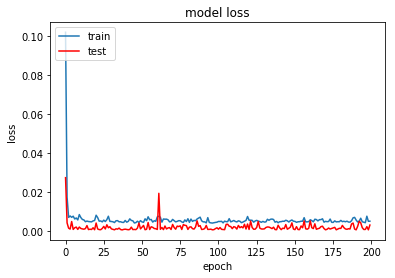

In [172]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], color=  'red')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

We now do the regression analysis between Calls answered and transferred calls percentage

In [173]:
regr_dataset.head()

,month,calls_answered,svc_level_answered_w_i_60_sec,avg_speed_answer_sec,transferred_calls
125,2007-04-01,91892,0.688,NaN,NaN
97,2007-05-01,111137,0.753,NaN,NaN
116,2007-06-01,141639,0.861,NaN,NaN
96,2007-08-01,173047,0.907,14.0,NaN
95,2007-09-01,175737,0.796,18.0,NaN


In [192]:
regr_dataset = regr_dataset.fillna(regr_dataset.mean())

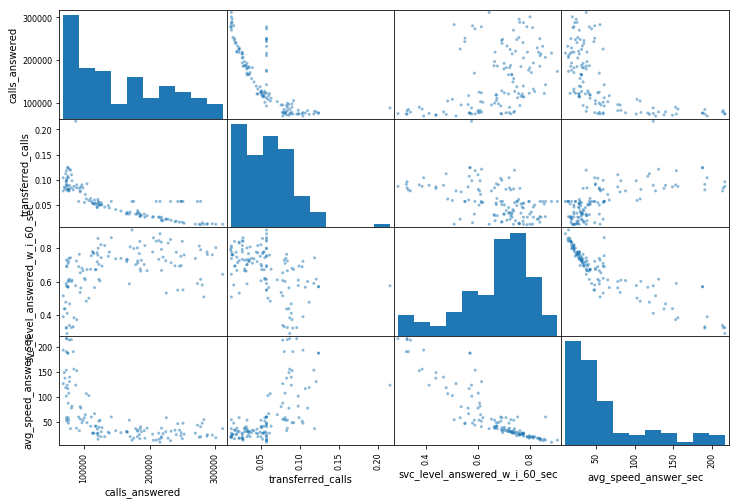

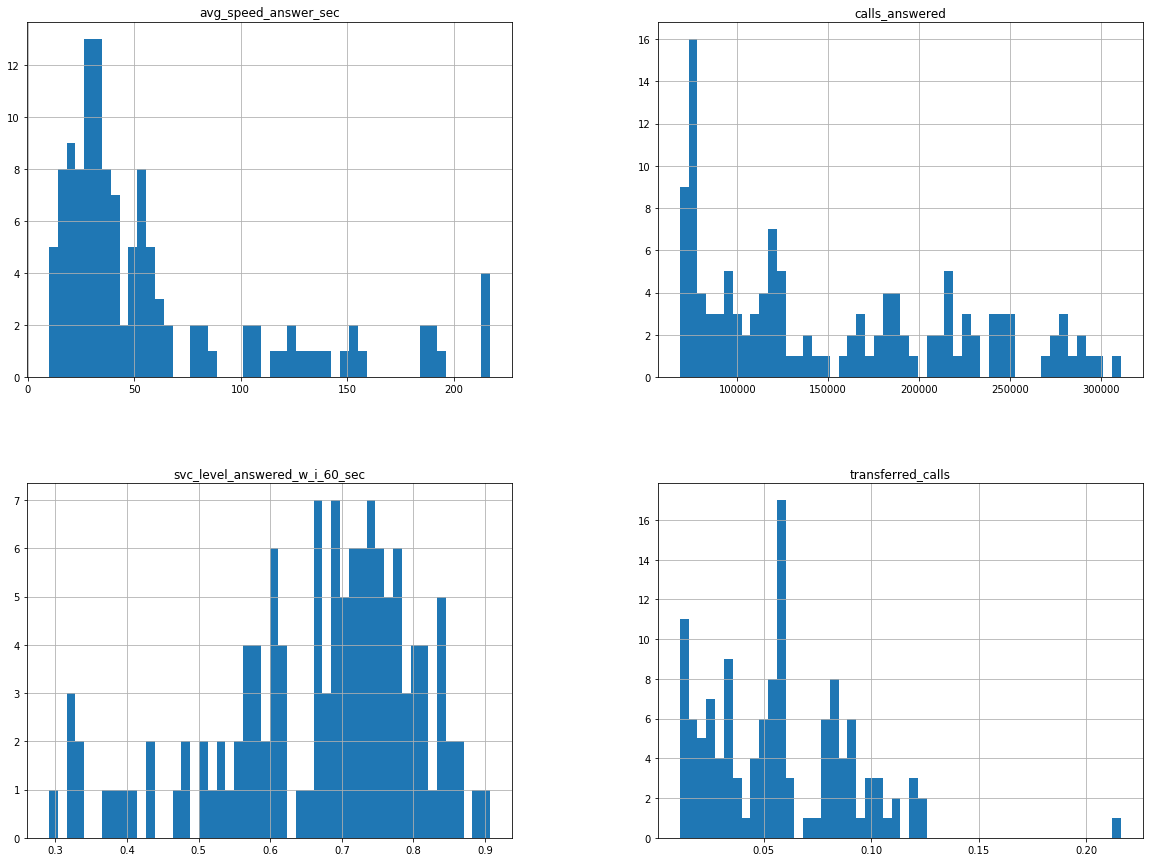

In [53]:
regr_dataset.hist(bins=50,figsize=(20,15))
plt.show()

In [49]:
attributes = ["calls_answered","transferred_calls","svc_level_answered_w_i_60_sec","avg_speed_answer_sec"]
scatter_matrix(regr_dataset[attributes],figsize=(12,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000194E26770B8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000194E4342B38>]], dtype=object)

The scatter matrix clearly shows relationship between avg_speed_answer_sec and calls_answered, and this is supported by
correlation matrix

In [193]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(regr_dataset, 0.2)
print(len(train_set), "train +", len(test_set), "test")

101 train + 25 test


In [194]:
train_X = train_set.iloc[:,1]
train_Y = train_set.iloc[:,4]
test_X = test_set.iloc[:,1]
test_Y = test_set.iloc[:,4]

In [195]:
m=train_X.isnull().any()
print(m[m])
m=test_X.isnull().any()
print(m[m])


[]
[]


In [196]:
scaler1 = StandardScaler()
train_X = train_X.values.reshape(train_X.shape[0],1)
test_X = test_X.values.reshape(test_X.shape[0],1)
train_X = scaler1.fit_transform(train_X)
test_X = scaler1.transform(test_X)

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [197]:
lin_reg = LinearRegression()
lin_reg.fit(train_X, train_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [198]:
callTransfer_predictions = lin_reg.predict(test_X)
lin_mse = mean_squared_error(test_Y, callTransfer_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

0.0164974683425


In [199]:
sgd_reg = SGDRegressor(max_iter=500,penalty=None,eta0=0.1)
sgd_reg.fit(train_X, train_Y.values.ravel())

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.1,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=500, n_iter=None, penalty=None,
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [200]:
callTransfer_predictions = sgd_reg.predict(test_X)
sgd_mse = mean_squared_error(test_Y, callTransfer_predictions)
sgd_rmse = np.sqrt(sgd_mse)
print(sgd_rmse)

0.0164716721291


We now fit Linear Regression between avg_Speed of calls answered and Call volume

In [201]:
train_Y = train_set.iloc[:,3]
test_Y = test_set.iloc[:,3]
train_Y = train_Y.ravel().reshape(train_Y.shape[0],1)
test_Y = test_Y.ravel().reshape(test_Y.shape[0],1)
train_X = train_X.reshape(train_X.shape[0],1)
test_X = test_X.reshape(test_X.shape[0],1)

In [149]:
lin_reg1 = LinearRegression()
lin_reg1.fit(train_X, train_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [150]:
callAnsTime_predictions = lin_reg1.predict(test_X)
lin_mse = mean_squared_error(test_Y, callAnsTime_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

36.3441069579


Based on the scatter matrix we find the relation between Call answer speed and Call answered volume is not liner. Hence we try Polynomial curve fitting and expt with diff degrees. We find degree=3 gives best fit on test data

In [202]:
poly = PolynomialFeatures(degree=3)
train_X_ = poly.fit_transform(train_X)
test_X_ = poly.fit_transform(test_X)
lin_reg2 = LinearRegression()
lin_reg2.fit(train_X_, train_Y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [203]:
callAnsTime_predictions = lin_reg2.predict(test_X_)
poly_mse = mean_squared_error(test_Y, callAnsTime_predictions)
poly_rmse = np.sqrt(poly_mse)
print(poly_rmse)

40.8082136726


In [217]:
print(testX.shape)
currData = testX[7,:,:]
currData = currData.reshape(1,currData.shape[0],currData.shape[1])
print(currData.shape)
currPredict = model.predict(currData)
currPredUnscaled = np.around(scaler.inverse_transform(currPredict))
print("prediction of Call Volume at time t+1:"+str(currPredUnscaled[:,0]))
print("prediction of Call Volume at time t+2:"+str(currPredUnscaled[:,1]))
print("prediction of Call Volume at time t+3:"+str(currPredUnscaled[:,2]))

(8, 10, 1)
(1, 10, 1)
prediction of Call Volume at time t+1:[ 73748.]
prediction of Call Volume at time t+2:[ 70488.]
prediction of Call Volume at time t+3:[ 68051.]


C:\Anaconda\lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input38716") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


Now we predict Calls tranferred percentage, and Average Speed of Answer in secs for next 3 months.

In [218]:
CallVol_X = currPredUnscaled[:,:].reshape(3,1)
CallVol_X = scaler1.fit_transform(CallVol_X)
CallVol_X_ = poly.fit_transform(CallVol_X)

In [219]:
callTransf_pred = lin_reg.predict(CallVol_X)
print(callTransf_pred)
callAnsTime_pred = lin_reg2.predict(CallVol_X_)
print(callAnsTime_pred)

[ 0.0238408   0.05927616  0.08576572]
[[  35.31411587]
 [  24.58427179]
 [ 122.36054926]]


We try a different approach to fit the Time Series data of Call Volumes, by using the stationary 
difference values as input to Deep Learning technique

In [7]:
from pandas import Series
n_lag = 1
n_seq = 3
n_test = 11

#use the Call volume column to create Series in pandas
series_call_volume=Series(data=dataframe.values[:,1])
print(len(series_call_volume))

# prepare data for normalization
values = series_call_volume.values
values = values.reshape((len(values), 1))
print(values)

126
[[91892]
 [111137]
 [141639]
 [173047]
 [175737]
 [209998]
 [215748]
 [231879]
 [247503]
 [248027]
 [242789]
 [250749]
 [277562]
 [272756]
 [311183]
 [282590]
 [280100]
 [269631]
 [287992]
 [300802]
 [277695]
 [295455]
 [287364]
 [275526]
 [252511]
 [232628]
 [238607]
 [245370]
 [225413]
 [218179]
 [240583]
 [249735]
 [220417]
 [228119]
 [217776]
 [224528]
 [204547]
 [187189]
 [186327]
 [168948]
 [178612]
 [164937]
 [185076]
 [205797]
 [192744]
 [214265]
 [218046]
 [213989]
 [196064]
 [185664]
 [191730]
 [181669]
 [181815]
 [170315]
 [181294]
 [184228]
 [165053]
 [166171]
 [156245]
 [148285]
 [138571]
 [136980]
 [127378]
 [118191]
 [122768]
 [114922]
 [120220]
 [131558]
 [120020]
 [125825]
 [122734]
 [124333]
 [117349]
 [116029]
 [121104]
 [121604]
 [126056]
 [113133]
 [113750]
 [121394]
 [100580]
 [110136]
 [103566]
 [107497]
 [102033]
 [94203]
 [94395]
 [96923]
 [104600]
 [92950]
 [98471]
 [95264]
 [83668]
 [89074]
 [84685]
 [80836]
 [75324]
 [74064]
 [77644]
 [73027]
 [74445]
 [

In [8]:
# normalize the values in a scale of 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)
print( ' Min: %f, Max: %f ' % (scaler.data_min_, scaler.data_max_))
# normalize the dataset and print
normalized = scaler.transform(values)
print(normalized)

 Min: 68355.000000, Max: 311183.000000 
[[  9.69286903e-02]
 [  1.76182318e-01]
 [  3.01793862e-01]
 [  4.31136442e-01]
 [  4.42214242e-01]
 [  5.83305879e-01]
 [  6.06985191e-01]
 [  6.73414927e-01]
 [  7.37756766e-01]
 [  7.39914672e-01]
 [  7.18343848e-01]
 [  7.51124253e-01]
 [  8.61543974e-01]
 [  8.41752187e-01]
 [  1.00000000e+00]
 [  8.82249988e-01]
 [  8.71995816e-01]
 [  8.28882995e-01]
 [  9.04496187e-01]
 [  9.57249576e-01]
 [  8.62091686e-01]
 [  9.35229875e-01]
 [  9.01909994e-01]
 [  8.53159438e-01]
 [  7.58380417e-01]
 [  6.76499415e-01]
 [  7.01121782e-01]
 [  7.28972771e-01]
 [  6.46787026e-01]
 [  6.16996393e-01]
 [  7.09259229e-01]
 [  7.46948457e-01]
 [  6.26212793e-01]
 [  6.57930716e-01]
 [  6.15336782e-01]
 [  6.43142471e-01]
 [  5.60857891e-01]
 [  4.89375196e-01]
 [  4.85825358e-01]
 [  4.14256181e-01]
 [  4.54053898e-01]
 [  3.97738317e-01]
 [  4.80673563e-01]
 [  5.66005568e-01]
 [  5.12251470e-01]
 [  6.00877988e-01]
 [  6.16448680e-01]
 [  5.99741381e-01]


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [9]:
#extract values from Time Series
values_call_volume = series_call_volume.values
	
# create Time Series from the difference of x(t) and x(t-1)
diff = list()
for i in range(1, len(values_call_volume)):
	value = values_call_volume[i] - values_call_volume[i - 1]
	diff.append(value)
	
diff_series = Series(diff)

In [10]:
#prepare values for Normalization
diff_values = diff_series.values
diff_values = diff_values.reshape(len(diff_values), 1)

# Normalize values in range -1, 1 using Sklearn MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_values = scaler.fit_transform(diff_values)
scaled_values = scaled_values.reshape(len(scaled_values), 1)

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [11]:
df = DataFrame(scaled_values)
cols = list()

#shift x values by 1 to create input sequence t-1
cols.append(df.shift(1))
    
#shift y values by 1,2,3 and create forecast sequence (t, t+1, t+2) at next 3 timesteps as y
for i in range(0, n_seq):
    cols.append(df.shift(-i))

In [12]:
#concat the values to create training dataset
agg = concat(cols, axis=1)
# drop rows with NaN values
agg.dropna(inplace=True)


In [28]:
#supervised training dataset with first column as x and next three columns as y
supervised_values = agg.values
print(supervised_values.shape)
supervised_values = supervised_values.reshape(len(supervised_values),4)

#Check the values against original data, and make sure these are indeed the difference values for the first four values in the series
print(scaler.inverse_transform(supervised_values[0,0]))
print(scaler.inverse_transform(supervised_values[0,1]))
print(scaler.inverse_transform(supervised_values[0,2]))
print(scaler.inverse_transform(supervised_values[0,3]))
#print(scaler.inverse_transform(supervised_values[121,0:3]))

(122, 4)
[[ 19245.]]
[[ 30502.]]
[[ 31408.]]
[[ 2690.]]


In [29]:

#use the 11 monthly values from 2017 as test data and all prev yrs as training data
train, test = supervised_values[0:-11], supervised_values[-11:]

print(train.shape)
print(test.shape)

(111, 4)
(11, 4)


In [30]:
# reshape training into [samples, timesteps, features]
X, y = train[:, 0:1], train[:, 1:]
X = X.reshape(X.shape[0], 1, X.shape[1])
print(X.shape)
print(y.shape)
X_test, y_test = test[:, 0:1], test[:, 1:]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print(X_test.shape)
print(y_test.shape)

(111, 1, 1)
(111, 3)
(11, 1, 1)
(11, 3)


In [31]:
# design network
def fit_model_stateful(n_cells):
    # define model
    model = Sequential()
    model.add(LSTM(n_cells, batch_input_shape=(1,X.shape[1],X.shape[2]),stateful=True))
    model.add(Dense(3))
    # compile model
    myOptimizer = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=0.01, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer=myOptimizer)
    model.fit(X, y, epochs=1500, shuffle=False, verbose=0,batch_size=1)
    model.reset_states()
    # evaluate model
    loss = model.evaluate(X_test, y_test, verbose=0, batch_size=1)
    return loss

In [32]:

def fit_model_stateless(n_cells):
    # define model
    model = Sequential()
    model.add(LSTM(n_cells, batch_input_shape=(1,X.shape[1],X.shape[2]),stateful=False))
    model.add(Dense(3))
    # compile model
    myOptimizer = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=0.01, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer=myOptimizer)
    model.fit(X, y, epochs=1500, shuffle=False, verbose=0,batch_size=1)
    # evaluate model
    loss = model.evaluate(X_test, y_test, verbose=0, batch_size=1)
    return loss


 >1/5 param=1.000000, loss=0.514470 
 >2/5 param=1.000000, loss=0.046064 
 >3/5 param=1.000000, loss=0.042042 
 >4/5 param=1.000000, loss=0.043794 
 >5/5 param=1.000000, loss=0.041865 
 >1/5 param=5.000000, loss=0.042109 
 >2/5 param=5.000000, loss=0.042341 
 >3/5 param=5.000000, loss=1.729358 
 >4/5 param=5.000000, loss=0.070479 
 >5/5 param=5.000000, loss=1.648085 
 >1/5 param=10.000000, loss=0.047736 
 >2/5 param=10.000000, loss=0.040581 
 >3/5 param=10.000000, loss=0.047498 
 >4/5 param=10.000000, loss=0.076228 
 >5/5 param=10.000000, loss=0.041913 
              1         5        10
count  5.000000  5.000000  5.000000
mean   0.137647  0.706474  0.050791
std    0.210657  0.897199  0.014580
min    0.041865  0.042109  0.040581
25%    0.042042  0.042341  0.041913
50%    0.043794  0.070479  0.047498
75%    0.046064  1.648085  0.047736
max    0.514470  1.729358  0.076228


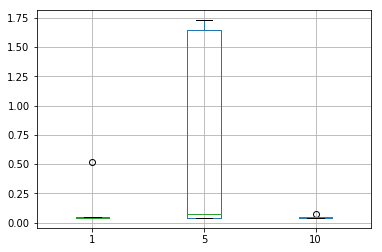

In [33]:

# define scope of search
params = [1, 5, 10]
n_repeats = 5
# grid search parameter values
scores = DataFrame()
for value in params:
# repeat each experiment multiple times
    loss_values_stateful = list()
    for i in range(n_repeats):
        loss = fit_model_stateful(value)
        loss_values_stateful.append(loss)
        print( ' >%d/%d param=%f, loss=%f ' % (i+1, n_repeats, value, loss))
# store results for this parameter
    scores[str(value)] = loss_values_stateful
# summary statistics of results
print(scores.describe())
# box and whisker plot of results
scores.boxplot()
plt.show()

We find 10 neurons in hidden layer gives best performance 

Train on 111 samples, validate on 11 samples
Epoch 1/1400
111/111 [==============================] - 2s 20ms/step - loss: 0.1481 - val_loss: 0.0440
Epoch 2/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1415 - val_loss: 0.0436
Epoch 3/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1401 - val_loss: 0.0431
Epoch 4/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1392 - val_loss: 0.0429
Epoch 5/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1387 - val_loss: 0.0428
Epoch 6/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1385 - val_loss: 0.0428
Epoch 7/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1383 - val_loss: 0.0428
Epoch 8/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1382 - val_loss: 0.0428
Epoch 9/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1381 - val_loss: 0.0428
Epoch 10/1400
111/111 [=============

111/111 [==============================] - 0s 2ms/step - loss: 0.1373 - val_loss: 0.0429
Epoch 81/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1373 - val_loss: 0.0429
Epoch 82/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1373 - val_loss: 0.0429
Epoch 83/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1373 - val_loss: 0.0429
Epoch 84/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1373 - val_loss: 0.0429
Epoch 85/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1373 - val_loss: 0.0429
Epoch 86/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1373 - val_loss: 0.0429
Epoch 87/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1373 - val_loss: 0.0429
Epoch 88/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1373 - val_loss: 0.0429
Epoch 89/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1373 - v

111/111 [==============================] - 0s 3ms/step - loss: 0.1369 - val_loss: 0.0429
Epoch 160/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1369 - val_loss: 0.0429
Epoch 161/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1369 - val_loss: 0.0429
Epoch 162/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1369 - val_loss: 0.0429
Epoch 163/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1369 - val_loss: 0.0429
Epoch 164/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1369 - val_loss: 0.0429
Epoch 165/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1369 - val_loss: 0.0429
Epoch 166/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1369 - val_loss: 0.0428
Epoch 167/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1368 - val_loss: 0.0428
Epoch 168/1400
111/111 [==============================] - 0s 2ms/step - loss: 0

Epoch 238/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1357 - val_loss: 0.0422
Epoch 239/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1357 - val_loss: 0.0422
Epoch 240/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1357 - val_loss: 0.0421
Epoch 241/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1357 - val_loss: 0.0421
Epoch 242/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1357 - val_loss: 0.0421
Epoch 243/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1356 - val_loss: 0.0421
Epoch 244/1400
111/111 [==============================] - 1s 5ms/step - loss: 0.1356 - val_loss: 0.0421
Epoch 245/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1356 - val_loss: 0.0421
Epoch 246/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1356 - val_loss: 0.0421
Epoch 247/1400
111/111 [==============================] - 0s 4ms

Epoch 317/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1338 - val_loss: 0.0412
Epoch 318/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1338 - val_loss: 0.0412
Epoch 319/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1338 - val_loss: 0.0412
Epoch 320/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1338 - val_loss: 0.0412
Epoch 321/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1338 - val_loss: 0.0412
Epoch 322/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1337 - val_loss: 0.0411
Epoch 323/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1337 - val_loss: 0.0411
Epoch 324/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1337 - val_loss: 0.0411
Epoch 325/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1337 - val_loss: 0.0411
Epoch 326/1400
111/111 [==============================] - 0s 2ms

C:\Anaconda\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109000). Check your callbacks.
  % delta_t_median)


111/111 [==============================] - 1s 7ms/step - loss: 0.1333 - val_loss: 0.0409
Epoch 345/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1332 - val_loss: 0.0409
Epoch 346/1400
111/111 [==============================] - 1s 6ms/step - loss: 0.1332 - val_loss: 0.0409
Epoch 347/1400
111/111 [==============================] - 1s 6ms/step - loss: 0.1332 - val_loss: 0.0409
Epoch 348/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1332 - val_loss: 0.0409
Epoch 349/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1332 - val_loss: 0.0408
Epoch 350/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1331 - val_loss: 0.0408
Epoch 351/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1331 - val_loss: 0.0408
Epoch 352/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1331 - val_loss: 0.0408
Epoch 353/1400
111/111 [==============================] - 0s 2ms/step - loss: 0

111/111 [==============================] - 0s 3ms/step - loss: 0.1316 - val_loss: 0.0404
Epoch 423/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1316 - val_loss: 0.0404
Epoch 424/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1316 - val_loss: 0.0404
Epoch 425/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1316 - val_loss: 0.0403
Epoch 426/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1316 - val_loss: 0.0403
Epoch 427/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1315 - val_loss: 0.0403
Epoch 428/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1315 - val_loss: 0.0403
Epoch 429/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1315 - val_loss: 0.0403
Epoch 430/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1315 - val_loss: 0.0402
Epoch 431/1400
111/111 [==============================] - 0s 2ms/step - loss: 0

Epoch 501/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1302 - val_loss: 0.0379
Epoch 502/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1302 - val_loss: 0.0379
Epoch 503/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1302 - val_loss: 0.0378
Epoch 504/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1302 - val_loss: 0.0378
Epoch 505/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1302 - val_loss: 0.0378
Epoch 506/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1302 - val_loss: 0.0378
Epoch 507/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1302 - val_loss: 0.0377
Epoch 508/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1302 - val_loss: 0.0377
Epoch 509/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1302 - val_loss: 0.0377
Epoch 510/1400
111/111 [==============================] - 0s 2ms

Epoch 580/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1298 - val_loss: 0.0365
Epoch 581/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1299 - val_loss: 0.0365
Epoch 582/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1299 - val_loss: 0.0365
Epoch 583/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1298 - val_loss: 0.0365
Epoch 584/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1298 - val_loss: 0.0365
Epoch 585/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1298 - val_loss: 0.0364
Epoch 586/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1298 - val_loss: 0.0364
Epoch 587/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1298 - val_loss: 0.0364
Epoch 588/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1298 - val_loss: 0.0364
Epoch 589/1400
111/111 [==============================] - 0s 2ms

Epoch 659/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1296 - val_loss: 0.0358
Epoch 660/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1296 - val_loss: 0.0358
Epoch 661/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1296 - val_loss: 0.0358
Epoch 662/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1296 - val_loss: 0.0358
Epoch 663/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1296 - val_loss: 0.0358
Epoch 664/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1296 - val_loss: 0.0357
Epoch 665/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1296 - val_loss: 0.0357
Epoch 666/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1296 - val_loss: 0.0357
Epoch 667/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1296 - val_loss: 0.0357
Epoch 668/1400
111/111 [==============================] - 0s 2ms

111/111 [==============================] - 0s 3ms/step - loss: 0.1294 - val_loss: 0.0354
Epoch 738/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1294 - val_loss: 0.0354
Epoch 739/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1294 - val_loss: 0.0354
Epoch 740/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1294 - val_loss: 0.0353
Epoch 741/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1294 - val_loss: 0.0354
Epoch 742/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1294 - val_loss: 0.0353
Epoch 743/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1294 - val_loss: 0.0353
Epoch 744/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1294 - val_loss: 0.0353
Epoch 745/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1294 - val_loss: 0.0353
Epoch 746/1400
111/111 [==============================] - 0s 2ms/step - loss: 0

111/111 [==============================] - 0s 2ms/step - loss: 0.1293 - val_loss: 0.0351
Epoch 816/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1293 - val_loss: 0.0351
Epoch 817/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1293 - val_loss: 0.0351
Epoch 818/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1293 - val_loss: 0.0351
Epoch 819/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1293 - val_loss: 0.0351
Epoch 820/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1293 - val_loss: 0.0351
Epoch 821/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1293 - val_loss: 0.0351
Epoch 822/1400
111/111 [==============================] - 1s 5ms/step - loss: 0.1293 - val_loss: 0.0351
Epoch 823/1400
111/111 [==============================] - 1s 6ms/step - loss: 0.1293 - val_loss: 0.0351
Epoch 824/1400
111/111 [==============================] - 0s 3ms/step - loss: 0

Epoch 894/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1291 - val_loss: 0.0349
Epoch 895/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1291 - val_loss: 0.0349
Epoch 896/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1291 - val_loss: 0.0349
Epoch 897/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1291 - val_loss: 0.0349
Epoch 898/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1291 - val_loss: 0.0349
Epoch 899/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1291 - val_loss: 0.0349
Epoch 900/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1291 - val_loss: 0.0349
Epoch 901/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1291 - val_loss: 0.0349
Epoch 902/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1291 - val_loss: 0.0349
Epoch 903/1400
111/111 [==============================] - 0s 2ms

Epoch 973/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1290 - val_loss: 0.0348
Epoch 974/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1290 - val_loss: 0.0348
Epoch 975/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1290 - val_loss: 0.0348
Epoch 976/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1290 - val_loss: 0.0348
Epoch 977/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1290 - val_loss: 0.0348
Epoch 978/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1290 - val_loss: 0.0348
Epoch 979/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1290 - val_loss: 0.0348
Epoch 980/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1290 - val_loss: 0.0348
Epoch 981/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1290 - val_loss: 0.0348
Epoch 982/1400
111/111 [==============================] - 0s 3ms

111/111 [==============================] - 0s 2ms/step - loss: 0.1289 - val_loss: 0.0347
Epoch 1052/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1289 - val_loss: 0.0347
Epoch 1053/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1289 - val_loss: 0.0347
Epoch 1054/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1289 - val_loss: 0.0347
Epoch 1055/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1289 - val_loss: 0.0347
Epoch 1056/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1289 - val_loss: 0.0347
Epoch 1057/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1289 - val_loss: 0.0347
Epoch 1058/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1289 - val_loss: 0.0347
Epoch 1059/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1289 - val_loss: 0.0347
Epoch 1060/1400
111/111 [==============================] - 0s 2ms/step 

111/111 [==============================] - 0s 3ms/step - loss: 0.1288 - val_loss: 0.0346
Epoch 1130/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1288 - val_loss: 0.0346
Epoch 1131/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1288 - val_loss: 0.0346
Epoch 1132/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1287 - val_loss: 0.0346
Epoch 1133/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1287 - val_loss: 0.0346
Epoch 1134/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1287 - val_loss: 0.0346
Epoch 1135/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1287 - val_loss: 0.0346
Epoch 1136/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1287 - val_loss: 0.0346
Epoch 1137/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1287 - val_loss: 0.0346
Epoch 1138/1400
111/111 [==============================] - 0s 3ms/step 

111/111 [==============================] - 0s 2ms/step - loss: 0.1286 - val_loss: 0.0346
Epoch 1208/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1286 - val_loss: 0.0345
Epoch 1209/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1286 - val_loss: 0.0345
Epoch 1210/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1286 - val_loss: 0.0345
Epoch 1211/1400
111/111 [==============================] - ETA: 0s - loss: 0.143 - 0s 2ms/step - loss: 0.1286 - val_loss: 0.0345
Epoch 1212/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1286 - val_loss: 0.0346
Epoch 1213/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1286 - val_loss: 0.0345
Epoch 1214/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1286 - val_loss: 0.0346
Epoch 1215/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1286 - val_loss: 0.0345
Epoch 1216/1400
111/111 [======================

111/111 [==============================] - 0s 3ms/step - loss: 0.1284 - val_loss: 0.0345
Epoch 1285/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1285 - val_loss: 0.0345
Epoch 1286/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1284 - val_loss: 0.0345
Epoch 1287/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1284 - val_loss: 0.0345
Epoch 1288/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1284 - val_loss: 0.0345
Epoch 1289/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1284 - val_loss: 0.0345
Epoch 1290/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1284 - val_loss: 0.0345
Epoch 1291/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1284 - val_loss: 0.0345
Epoch 1292/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1284 - val_loss: 0.0345
Epoch 1293/1400
111/111 [==============================] - 0s 4ms/step 

111/111 [==============================] - 0s 3ms/step - loss: 0.1283 - val_loss: 0.0345
Epoch 1363/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1283 - val_loss: 0.0345
Epoch 1364/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1283 - val_loss: 0.0345
Epoch 1365/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1283 - val_loss: 0.0345
Epoch 1366/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1283 - val_loss: 0.0345
Epoch 1367/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1283 - val_loss: 0.0345
Epoch 1368/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1283 - val_loss: 0.0345
Epoch 1369/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1283 - val_loss: 0.0345
Epoch 1370/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1283 - val_loss: 0.0345
Epoch 1371/1400
111/111 [==============================] - 0s 3ms/step 

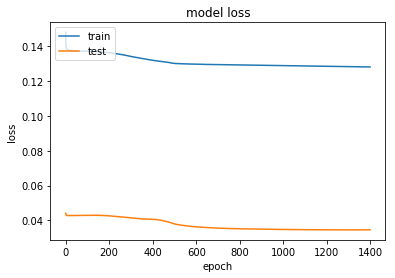

In [34]:
#Based on error plot, choose 5 neurons in intermediate layer
model = Sequential()
model.add(LSTM(10, batch_input_shape=(1, 1, 1), stateful=False))
model.add(Dense(3))
myOptimizer = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=0.01, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=myOptimizer)
history = model.fit(X, y, epochs=1400, validation_data=(X_test,y_test), batch_size=1, verbose=1, shuffle=False)
loss = model.evaluate(X_test,y_test,batch_size=1,verbose=0)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
#Save the model
model.save('C:/users/hackuser1/lstm_time_series_stless.h5')

#Load model
#model = load_model('C:/users/hackuser1/lstm_time_series_stless.h5')

In [36]:
# make forecast
forecasts = list()
	
for i in range(len(test)):
    X_test_inp = X_test[i,0,0]
    X_test_inp = X_test_inp.reshape(1,1,1)
    forecast = model.predict(X_test_inp, batch_size=1)
    forecasts.append(forecast)
    
print(forecasts)

[array([[-0.10767417, -0.1920864 , -0.23942053]], dtype=float32), array([[-0.15367219, -0.18177706, -0.08998713]], dtype=float32), array([[-0.09960766, -0.19542798, -0.2835747 ]], dtype=float32), array([[-0.19831343, -0.18253753, -0.09714389]], dtype=float32), array([[-0.47409001, -0.05098829, -0.16723399]], dtype=float32), array([[-0.11316969, -0.19346721, -0.27819183]], dtype=float32), array([[-0.28970632, -0.16052581, -0.13368607]], dtype=float32), array([[-0.10513038, -0.1932331 , -0.25337875]], dtype=float32), array([[-0.22214893, -0.17947021, -0.10843343]], dtype=float32), array([[-0.15215982, -0.1817058 , -0.09112343]], dtype=float32), array([[-0.17823154, -0.18308119, -0.08862606]], dtype=float32)]


In [37]:
# invert difference values to have absolute value
def inverse_difference(last_ob, unscaled_diff):
	inverted = list()
	inverted.append(last_ob+unscaled_diff[0])
	for i in range(1, len(unscaled_diff)):
		inverted.append(inverted[i-1]+unscaled_diff[i])
	return inverted

inverted = list()
for i in range(len(forecasts)):
	# create array from forecast
	forecast = np.array(forecasts[i])
    #the 3 step values of call volume into the future
	forecast = forecast.reshape(1, 3)
	# invert scaling
	inv_scale = scaler.inverse_transform(forecast)
	inv_scale = inv_scale[0, :]

	index = len(series_call_volume) - (n_test+2) + i - 1
	last_ob = series_call_volume.values[index]
    
    #get actual value of call volume based on forecast difference, and actual
	inv_diff = inverse_difference(last_ob, inv_scale)
	inverted.append(inv_diff)

inverted = np.around(inverted, decimals=0)

forecasts_inv = inverted
print(forecasts_inv)


[[ 82672.  80720.  77165.]
 [ 80268.  78665.  80172.]
 [ 75210.  73144.  68094.]
 [ 74101.  72473.  73737.]
 [ 77103.  79930.  78820.]
 [ 74194.  72195.  67327.]
 [ 74151.  73269.  73295.]
 [ 74420.  72430.  68402.]
 [ 73877.  72352.  73234.]
 [ 75270.  73670.  75138.]
 [ 75409.  73762.  75315.]]


In [38]:
#get actual values of Call volume for the 3 time steps, by taking from index=n_lag onwards
actuals = [row[n_lag:] for row in test]
print(test)
print(actuals)

[[-0.3004945  -0.15943612 -0.33786995 -0.06847738]
 [-0.15943612 -0.33786995 -0.06847738  0.22993579]
 [-0.33786995 -0.06847738  0.22993579 -0.58125323]
 [-0.06847738  0.22993579 -0.58125323  0.04081482]
 [ 0.22993579 -0.58125323  0.04081482 -0.31109307]
 [-0.58125323  0.04081482 -0.31109307 -0.03349325]
 [ 0.04081482 -0.31109307 -0.03349325 -0.16330356]
 [-0.31109307 -0.03349325 -0.16330356 -0.10428814]
 [-0.03349325 -0.16330356 -0.10428814 -0.1622998 ]
 [-0.16330356 -0.10428814 -0.1622998  -0.35531774]
 [-0.10428814 -0.1622998  -0.35531774 -0.00078235]]
[array([-0.15943612, -0.33786995, -0.06847738]), array([-0.33786995, -0.06847738,  0.22993579]), array([-0.06847738,  0.22993579, -0.58125323]), array([ 0.22993579, -0.58125323,  0.04081482]), array([-0.58125323,  0.04081482, -0.31109307]), array([ 0.04081482, -0.31109307, -0.03349325]), array([-0.31109307, -0.03349325, -0.16330356]), array([-0.03349325, -0.16330356, -0.10428814]), array([-0.16330356, -0.10428814, -0.1622998 ]), array

In [39]:
# invert scaling of actual values and get actual call volume from difference
inverted = list()
for i in range(len(actuals)):
	actual = np.array(actuals[i])
	actual = actual.reshape(1, 3)

	inv_scale = scaler.inverse_transform(actual)
	inv_scale = inv_scale[0, :]

	index = len(series_call_volume) - (n_test+2) + i - 1
	last_ob = series_call_volume.values[index]
	inv_diff = inverse_difference(last_ob, inv_scale)

	inverted.append(inv_diff)

inverted = np.around(inverted, decimals=0)

actuals_inv = inverted
print(actuals_inv)

[[ 80919.  74029.  76264.]
 [ 74029.  76264.  88607.]
 [ 76264.  88607.  73473.]
 [ 88607.  73473.  79410.]
 [ 73473.  79410.  73427.]
 [ 79410.  73427.  76847.]
 [ 73427.  76847.  75870.]
 [ 76847.  75870.  76892.]
 [ 75870.  76892.  75949.]
 [ 76892.  75949.  68468.]
 [ 75949.  68468.  72996.]]


In [42]:
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(actuals, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in actuals]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))

In [43]:
# evaluate forecasts
print(len(actuals_inv))
evaluate_forecasts(actuals_inv, forecasts_inv, n_lag, n_seq)

11
t+1 RMSE: 5284.846914
t+2 RMSE: 5806.692346
t+3 RMSE: 5944.753653


(11, 3)


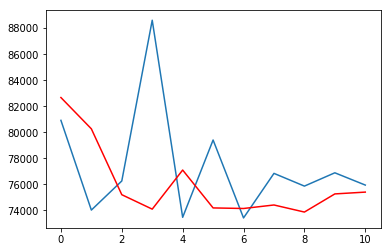

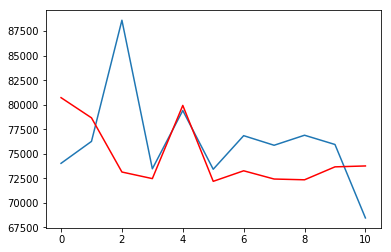

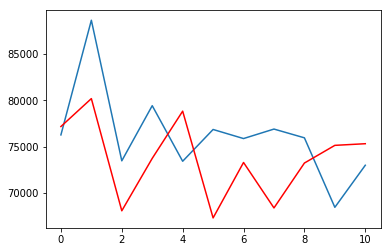

In [45]:
# plot forecastss
print(actuals_inv.shape)
plt.plot(actuals_inv[:,0])
plt.plot(forecasts_inv[:,0],color='red')
plt.show()

plt.plot(actuals_inv[:,1])
plt.plot(forecasts_inv[:,1],color='red')
plt.show()

plt.plot(actuals_inv[:,2])
plt.plot(forecasts_inv[:,2],color='red')
plt.show()
